In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from class_pig import pigClass  

from pathlib import Path
import pickle

"""
CUIDADO!!
"""
import warnings
warnings.filterwarnings("ignore")

In [2]:
from fitterClass import funcFitter
from utils import exponential_cicle, find_best_b, plot_exponentials
from collections import namedtuple

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# função usada para fitar o modelo PV sigmoide (doente)
#                b                                   b
# V(x) = a + ----------------------   = a + ------------------------
#            1 + exp(-(x/d) + (c/d)          1 + exp(-x/d).exp(c/d)
#
# lim (x-> inf)  V(x) = a + b
def sigmoid(x, a, b, c, d):
    return a + b/(1 + np.exp(-(x-c)/d))

# função usada para fitar o modelo PV exponencial (saudável)
def exponential(x, a, b, c, d):
    return a - b*np.exp(-(x-c)/d)

# função usada só para plotar as exponenciais PV a cada passo de pressão
# o primeiro termo depois é fixado (usando função partial())
#
# v(x) = c - a.exp(-bx)   ->   lim (x->inf) v(x) = c
#
def exponential_cicle_fixed_b(best_b, x, a, c):
    return -a*np.exp(-best_b*x)+c

# estimadores usados para testar os modelos...
estimators = ["lm", "trf", "dogbox"]
funcs = [sigmoid, exponential]

In [5]:
# verifica quais dados estão disponíveis para análise
for file_name in Path('porquinhos').rglob('*.pickle'):
    print(file_name.name)

porquinho_mra34.pickle
porquinho_mra28.pickle
porquinho_mra31.pickle
porquinho_mra32.pickle
porquinho_mra26.pickle
porquinho_mra29.pickle
porquinho_mra33.pickle


In [6]:
dataframes_lst = [] # lista de dataframes contendo possíveis configurações de testes

for file_name in Path('porquinhos').rglob('*.pickle'):
    
    #if file_name.name == "porquinho_mra26.pickle": # descomentar para testar só um porquinho
        #print(f"\rRodando {file_name.name}\t\t\t", end="")
        print(f"\rRodando {file_name.name}\t\t\t")
        
        with open(file_name, "rb") as file: # abre o arquivo.pickle

            porquinho = pickle.load(file)
            for manobra in porquinho: #Para cada manobra 

                if manobra == "D": # Posso fazer 3,4,5 passos
                    n_steps = 5
                elif manobra == "C": # Posso fazer 3,4 passos
                    n_steps = 4
                elif manobra == "B": # Posso fazer 3 passos
                    n_steps = 3

                # Formato os dados de entrada
                format_data = []

                for pi, pe, wi, we in zip(porquinho[manobra]["p_i"], porquinho[manobra]["p_e"],
                                          porquinho[manobra]["w_i"], porquinho[manobra]["w_e"]):

                    format_data.extend([pi,wi,pe,we])

                format_data = np.array(format_data).reshape(-1,2) # monta matriz de N linhas e 2 colunas

                ##########################################################

                for n_point in range(3,n_steps+1):
                    fitter = funcFitter(porquinho.name, manobra, format_data, format_data[0::2, :], n_point = n_point, estimators = estimators)
                    dataframes_lst.append(fitter.fit(funcs=funcs, interpolate=True, n_interp_point=20, interp_method="linear"))

Rodando porquinho_mra34.pickle			
Rodando porquinho_mra28.pickle			
Rodando porquinho_mra31.pickle			
Rodando porquinho_mra32.pickle			
Rodando porquinho_mra26.pickle			
vols: [[-147.32270813  -36.04450607  131.81762695]
 [-146.35787909  -31.64950069  132.32562339]]
raw: [[  10.13125038 -147.32270813]
 [  20.48750019  -20.93951035]
 [  15.11250019  -36.04450607]
 [  25.60937595   91.40720367]
 [  20.27187538  131.81762695]
 [  30.64687538  261.22961426]
 [  25.3125      568.52923584]
 [  35.65937614  749.08044434]]
erro: 2.6143850601199
vols: [[-147.32270813  -36.04450607  131.81762695]
 [-145.36772307  -30.89392974  132.88671731]]
raw: [[  10.13125038 -147.32270813]
 [  20.48750019  -20.93951035]
 [  15.11250019  -36.04450607]
 [  25.60937595   91.40720367]
 [  20.27187538  131.81762695]
 [  30.64687538  261.22961426]
 [  25.3125      568.52923584]
 [  35.65937614  749.08044434]]
erro: 3.240028671951355
vols: [[-147.32270813  -36.04450607  131.81762695]
 [-144.74535315  -31.1684876   

In [7]:
# junta todos os dataframes em um único
# mais rápido que acrescentar linha a linha no dataframe principal
df = pd.concat(dataframes_lst,ignore_index=True)
print(len(df))

464


In [8]:
# conta testes possíveis de cada caso/manobra/n_passos
# pode ter testes faltando pois são os que não fitaram (dentro de um try/except)
dataframes_lst[4].groupby(["subject", "manobra", "n_point"]).count()

function  function_name  estimator  error  param  \
subject manobra n_point                                                     
mra34   D       5              10             10         10     10     10   

                         interp_point  interp_pressure  interp_volume  \
subject manobra n_point                                                 
mra34   D       5                  10               10             10   

                         raw_data  
subject manobra n_point            
mra34   D       5              10

In [9]:
# escolhe grupo de teste
def getMinError(x):
    idx = x.error.idxmin()
    return x.loc[idx]
    
if False:
    # pega um subgrupo para teste (manobra D, menores erros gerais)
    df_test = df.query("manobra == 'D'")\
                .sort_values(by = "error")\
                .reset_index(drop=True)\
                .loc[0:5]\
                .copy()
else:
    # pega o melhor fit de cada caso/manobra/n_points
    #df_test = df.groupby(["subject", "manobra", "n_point"])["error"].min().copy()
    #df_test = df.reset_index().groupby(["subject", "manobra", "n_point"],as_index = False)["error"].min()
    df_test=df.groupby(["subject", "manobra", "n_point"]).apply(getMinError).reset_index(drop=True)

In [10]:
for i in range(15):
    print(f'{i}: {df_test.iloc[i].param} {df_test.iloc[i].error}')

0: [-209.43114205  743.27605242   20.25446458    4.29784436] 4.450242663201826
1: [-301.84501674 1026.86706483   22.50672788    7.18037126] 2.614382336533242
2: [-207.76631438 4999.99999978   35.44742724    6.01469086] 17.707776881814695
3: [-268.03681418  723.71298882   20.32011782    4.60652406] 4.011312362235502
4: [-299.06671287 1615.94637462   27.51805011    6.47556378] 5.555965916217024
5: [-296.68603806 1708.2337167    28.17395385    6.44961456] 0.4767349517545508
6: [-250.03060526 1003.00905831   20.95269833    5.55060486] 3.887819717239582
7: [-192.91426113  695.23515701   18.74017827    3.13158032] 6.884995566347325
8: [-244.38206381 1077.16003888   21.24709738    4.56675843] 8.646638971834124
9: [-261.08405018  819.36795923   19.35231244    4.19167948] 5.284981220769538
10: [-308.25350155 1387.44391834   23.51538445    5.85325997] 5.582552481003429
11: [-303.05620723 1407.45564565   23.79527109    5.78060317] 2.498426640030906
12: [-906.77539915 2242.68510433   25.3767788   

In [11]:
# Verificando um exemplo de menor erro
caso = 1
print(df_test.iloc[caso].param)

[-301.84501674 1026.86706483   22.50672788    7.18037126]


In [12]:
df_test

subject manobra  n_point                                  function  \
0    mra26       B        3      <function sigmoid at 0x7f50a988adc0>   
1    mra26       C        3      <function sigmoid at 0x7f50a988adc0>   
2    mra26       C        4      <function sigmoid at 0x7f50a988adc0>   
3    mra26       D        3      <function sigmoid at 0x7f50a988adc0>   
4    mra26       D        4      <function sigmoid at 0x7f50a988adc0>   
5    mra26       D        5      <function sigmoid at 0x7f50a988adc0>   
6    mra28       B        3      <function sigmoid at 0x7f50a988adc0>   
7    mra28       C        3      <function sigmoid at 0x7f50a988adc0>   
8    mra28       C        4      <function sigmoid at 0x7f50a988adc0>   
9    mra28       D        3      <function sigmoid at 0x7f50a988adc0>   
10   mra28       D        4      <function sigmoid at 0x7f50a988adc0>   
11   mra28       D        5      <function sigmoid at 0x7f50a988adc0>   
12   mra29       B        3      <function sigmoid at 0x7f50a988adc0>   
13   mra29       C        3      <function sigmoid at 0x7f50a988adc0>   
14   mra29       C        4      <function sigmoid at 0x7f50a988adc0>   
15   mra29       D        3      <function sigmoid at 0x7f50a988adc0>   
16   mra29       D        4      <function sigmoid at 0x7f50a988adc0>   
17   mra29       D        5      <function sigmoid at 0x7f50a988adc0>   
18   mra31       B        3      <function sigmoid at 0x7f50a988adc0>   
19   mra31       C        3      <function sigmoid at 0x7f50a988adc0>   
20   mra31       C        4      <function sigmoid at 0x7f50a988adc0>   
21   mra31       D        3      <function sigmoid at 0x7f50a988adc0>   
22   mra31       D        4      <function sigmoid at 0x7f50a988adc0>   
23   mra31       D        5      <function sigmoid at 0x7f50a988adc0>   
24   mra32       B        3      <function sigmoid at 0x7f50a988adc0>   
25   mra32       C        3      <function sigmoid at 0x7f50a988adc0>   
26   mra32       C        4  <function exponential at 0x7f50a988ad30>   
27   mra32       D        3      <function sigmoid at 0x7f50a988adc0>   
28   mra32       D        4      <function sigmoid at 0x7f50a988adc0>   
29   mra32       D        5      <function sigmoid at 0x7f50a988adc0>   
30   mra33       B        3      <function sigmoid at 0x7f50a988adc0>   
31   mra33       C        3      <function sigmoid at 0x7f50a988adc0>   
32   mra33       C        4      <function sigmoid at 0x7f50a988adc0>   
33   mra33       D        3      <function sigmoid at 0x7f50a988adc0>   
34   mra33       D        4      <function sigmoid at 0x7f50a988adc0>   
35   mra33       D        5      <function sigmoid at 0x7f50a988adc0>   
36   mra34       B        3      <function sigmoid at 0x7f50a988adc0>   
37   mra34       C        3      <function sigmoid at 0x7f50a988adc0>   
38   mra34       C        4      <function sigmoid at 0x7f50a988adc0>   
39   mra34       D        3      <function sigmoid at 0x7f50a988adc0>   
40   mra34       D        4      <function sigmoid at 0x7f50a988adc0>   
41   mra34       D        5      <function sigmoid at 0x7f50a988adc0>   

   function_name estimator      error  \
0        sigmoid    dogbox   4.450243   
1        sigmoid    dogbox   2.614382   
2        sigmoid       trf  17.707777   
3        sigmoid    dogbox   4.011312   
4        sigmoid       trf   5.555966   
5        sigmoid    dogbox   0.476735   
6        sigmoid    dogbox   3.887820   
7        sigmoid    dogbox   6.884996   
8        sigmoid    dogbox   8.646639   
9        sigmoid    dogbox   5.284981   
10       sigmoid       trf   5.582552   
11       sigmoid    dogbox   2.498427   
12       sigmoid    dogbox   1.019571   
13       sigmoid       trf   5.326851   
14       sigmoid       trf   5.617353   
15       sigmoid    dogbox   2.820528   
16       sigmoid       trf   6.925458   
17       sigmoid    dogbox   7.161540   
18       sigmoid       trf   1.281029   
19       sigmoid    dogbox   3.967576   
20

<AxesSubplot:>

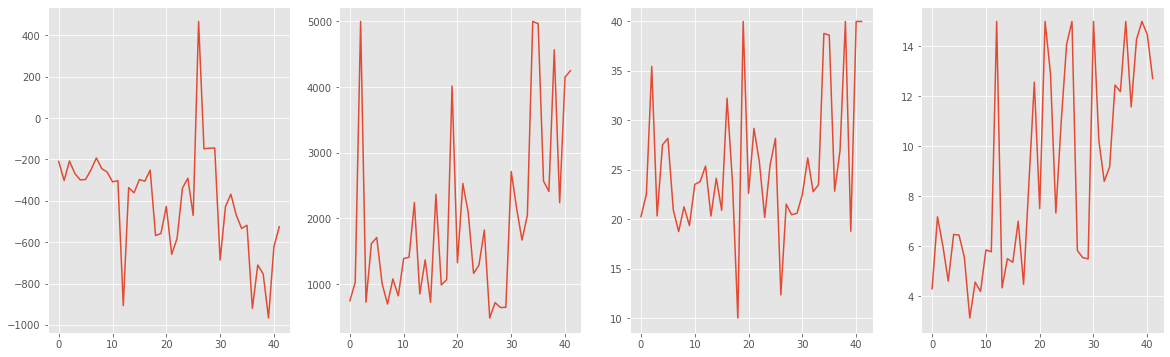

In [13]:
fig, axs = plt.subplots(1,4,figsize = (20,6))

df_test.param.apply(lambda x: x[0]).plot(ax = axs[0])
df_test.param.apply(lambda x: x[1]).plot(ax = axs[1])
df_test.param.apply(lambda x: x[2]).plot(ax = axs[2])
df_test.param.apply(lambda x: x[3]).plot(ax = axs[3])

In [14]:
df_test.iloc[12].raw_data

array([[  10.26111126, -307.44592285],
       [  20.3279171 , -153.94024658],
       [  15.11791658, -156.3163147 ],
       [  25.30250072,   -8.01654243],
       [  20.02986145,   16.64159584],
       [  30.32625103,  171.26463318]])

In [15]:
# b esperado nas exponenciais...
a, b, c, d = df_test.iloc[caso].param
print(f'b estimado para exp com base na sigmoide: {np.exp(c/d)/(b)}')

b estimado para exp com base na sigmoide: 0.022375513390019194


In [16]:
# chama a função find_best_b para cada linha do dataframe
df_test[["best_b", "guess_zero"]] = df_test.apply(find_best_b, axis=1, result_type="expand")

(0.14981345731592202, [0, -202.8155850760244])
(0.022375513390019194, [0, -259.017270742269])
(0.07253263450174244, [0, -194.01732801716764])
(0.11380893917778244, [0, -259.3555579781401])
(0.04336276524883324, [0, -276.3299308311889])
(0.04619427997076385, [0, -275.3092351265595])
(0.04346017577311451, [0, -227.53704863000442])
(0.5712124058765868, [0, -191.16799611762255])
(0.09734171178434761, [0, -234.206026395084])
(0.12347784713634895, [0, -253.06469466555353])
(0.04004572419686818, [0, -283.72354100873713])
(0.04358076026140453, [0, -280.4783905264945])
(0.0024208322788468024, [0, -557.9454528662718])
(0.12739074759790417, [0, -328.6471823769673])
(0.058591315299673825, [0, -344.616711550147])
(0.06832370999012072, [0, -282.468501626869])
(0.042046993567646, [0, -281.85907800552195])
(0.205844110081041, [0, -246.8282912345284])
(0.003011425169930862, [0, -314.80454423184756])
(0.0060009882201618545, [0, -398.1327207165226])
(0.015348843229600477, [0, -364.8175580515302])
(0.0027

Best b: 0.14981345731592202
Best zero: [0, -202.8155850760244]


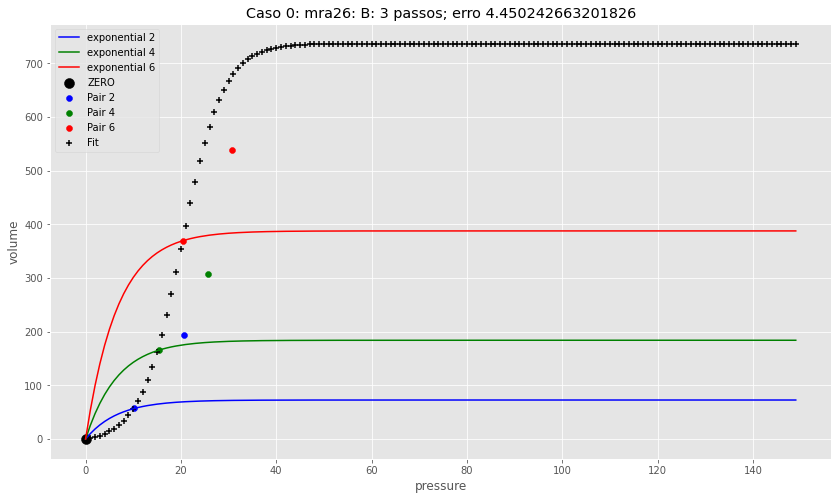

Best b: 0.022375513390019194
Best zero: [0, -259.017270742269]


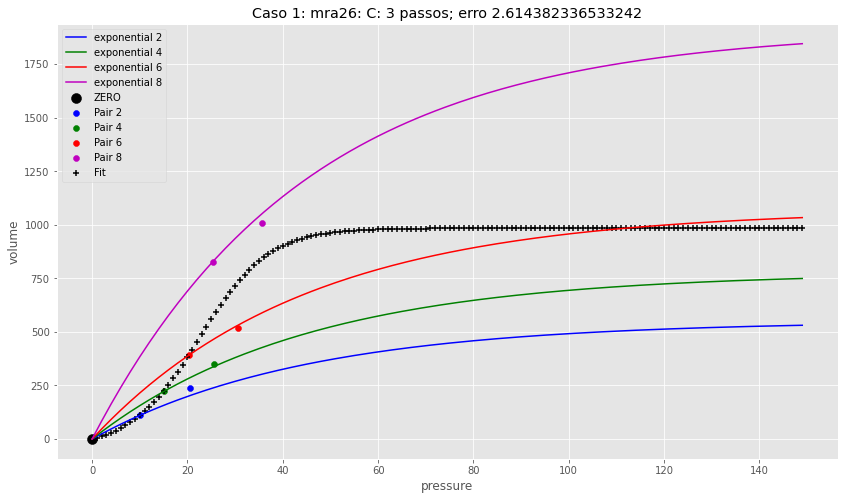

Best b: 0.07253263450174244
Best zero: [0, -194.01732801716764]


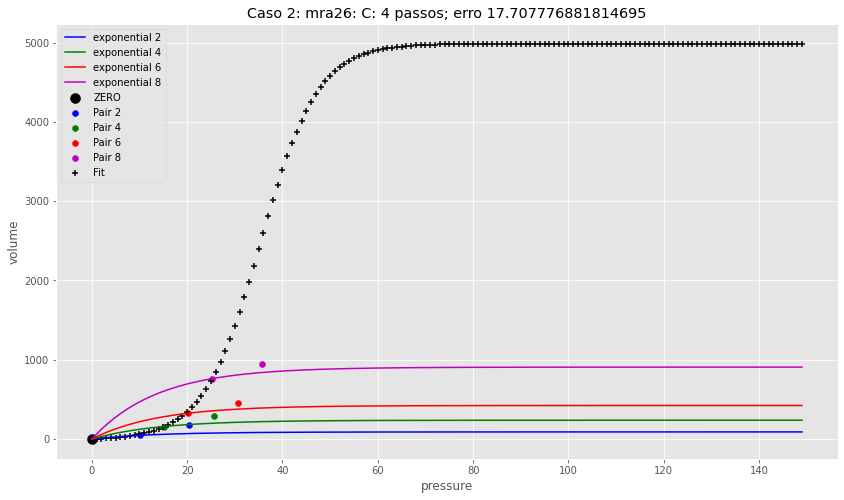

Best b: 0.11380893917778244
Best zero: [0, -259.3555579781401]


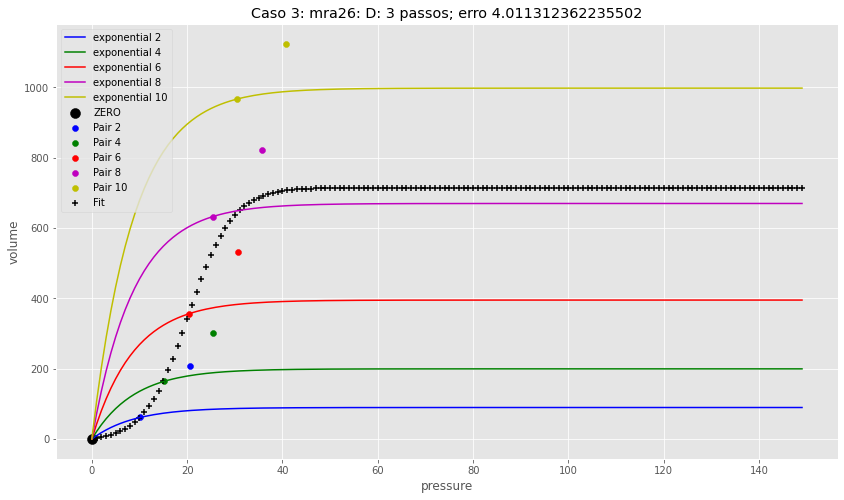

Best b: 0.04336276524883324
Best zero: [0, -276.3299308311889]


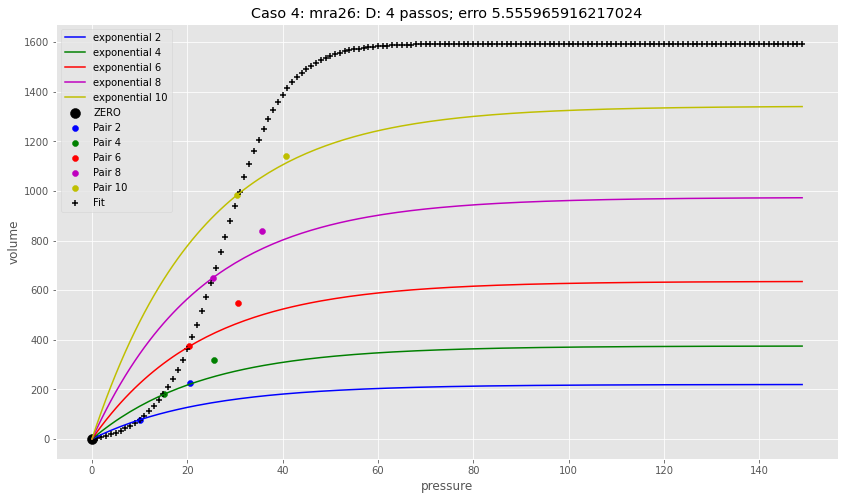

Best b: 0.04619427997076385
Best zero: [0, -275.3092351265595]


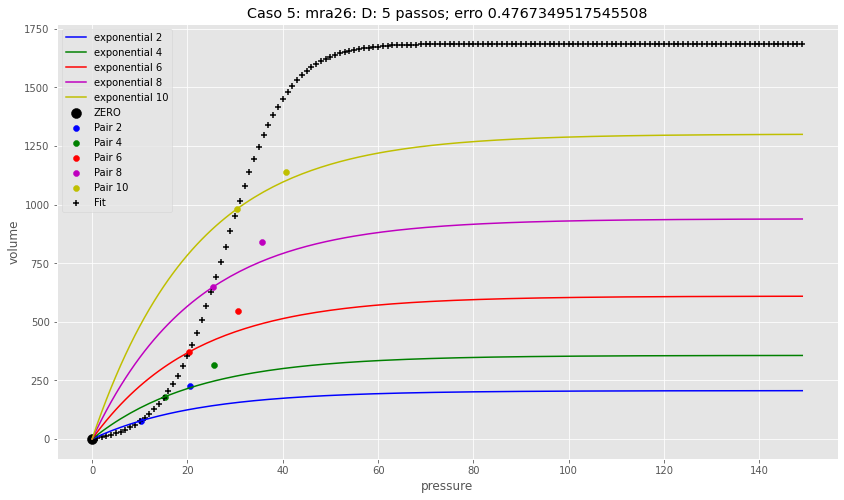

Best b: 0.04346017577311451
Best zero: [0, -227.53704863000442]


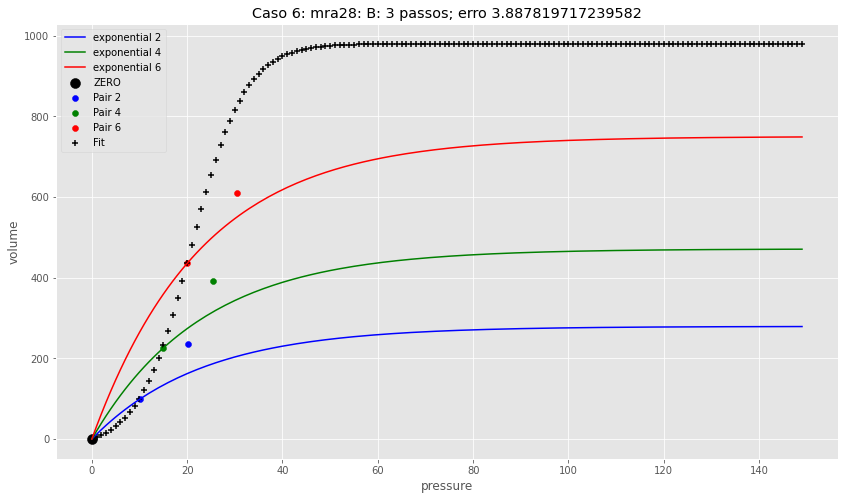

Best b: 0.5712124058765868
Best zero: [0, -191.16799611762255]


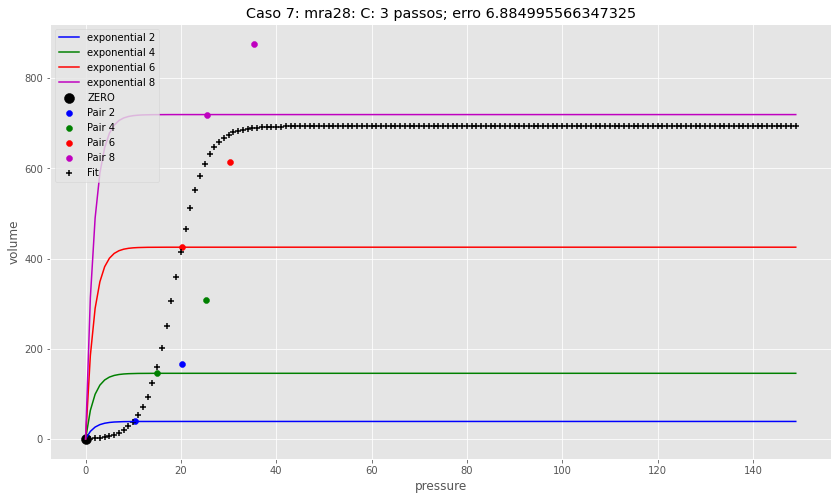

Best b: 0.09734171178434761
Best zero: [0, -234.206026395084]


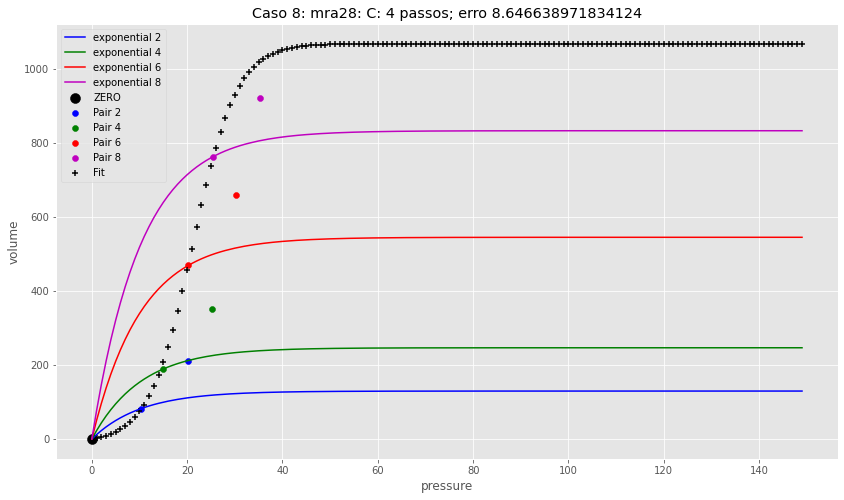

Best b: 0.12347784713634895
Best zero: [0, -253.06469466555353]


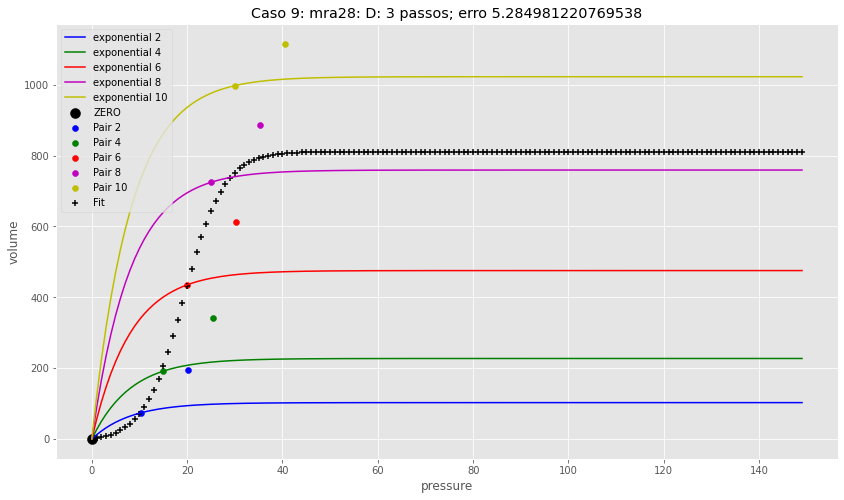

Best b: 0.04004572419686818
Best zero: [0, -283.72354100873713]


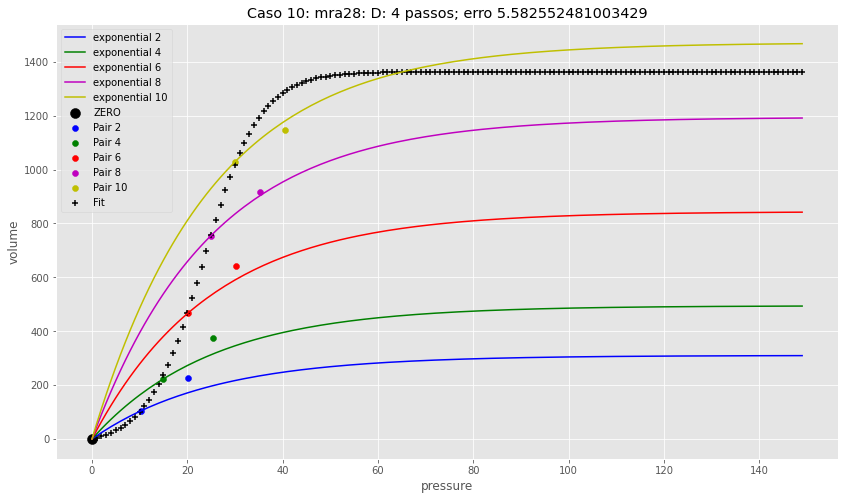

Best b: 0.04358076026140453
Best zero: [0, -280.4783905264945]


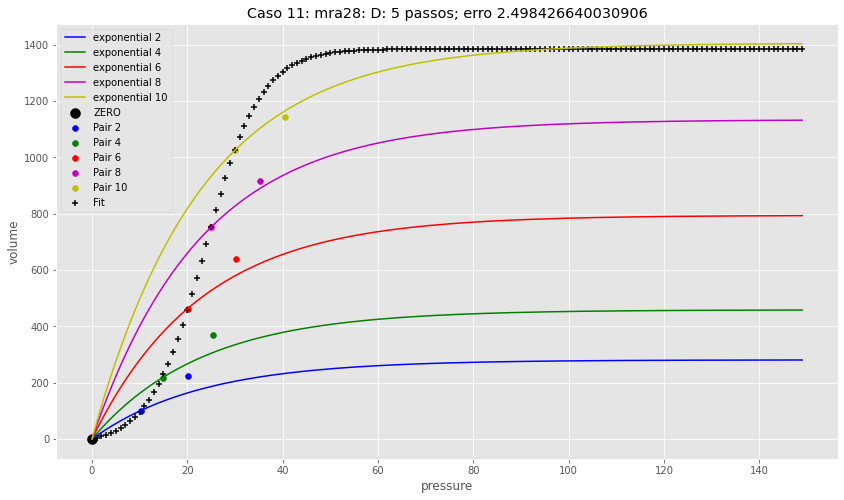

Best b: 0.0024208322788468024
Best zero: [0, -557.9454528662718]


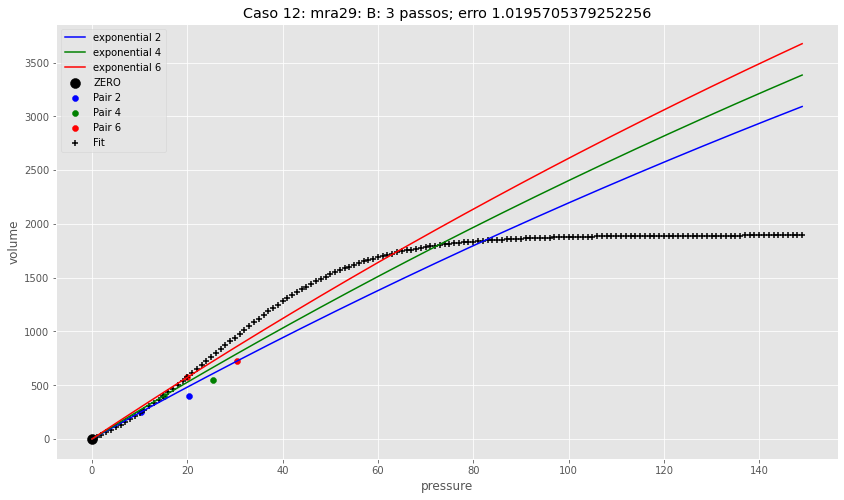

Best b: 0.12739074759790417
Best zero: [0, -328.6471823769673]


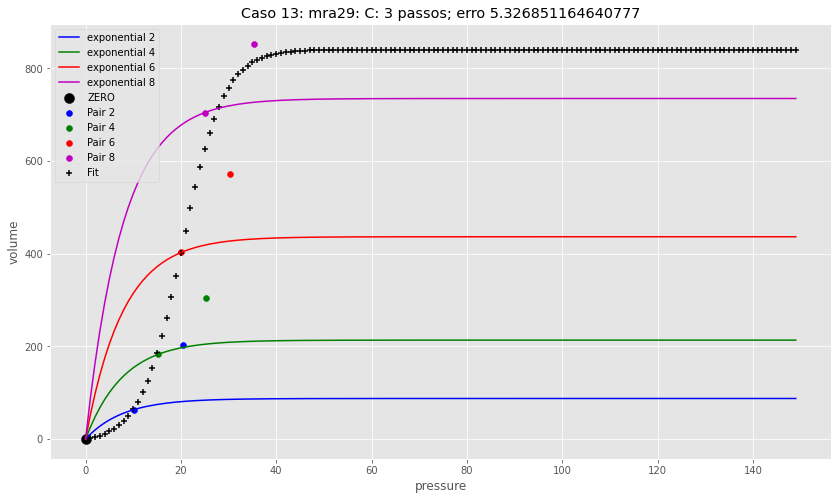

Best b: 0.058591315299673825
Best zero: [0, -344.616711550147]


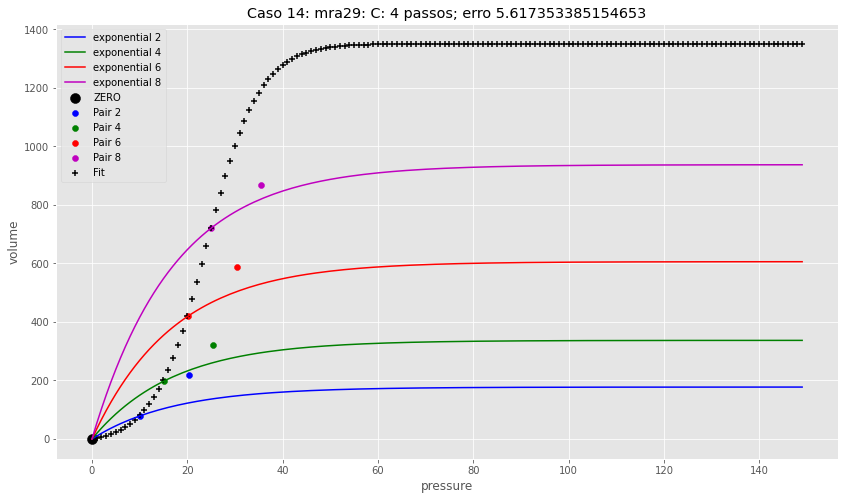

Best b: 0.06832370999012072
Best zero: [0, -282.468501626869]


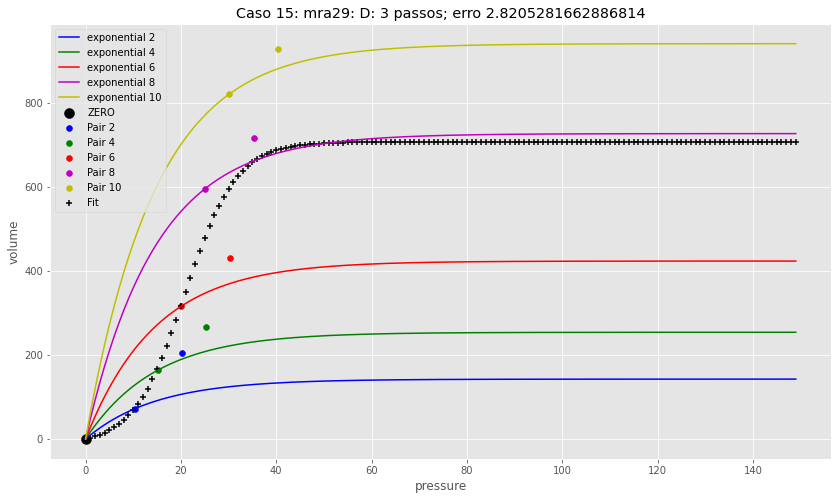

Best b: 0.042046993567646
Best zero: [0, -281.85907800552195]


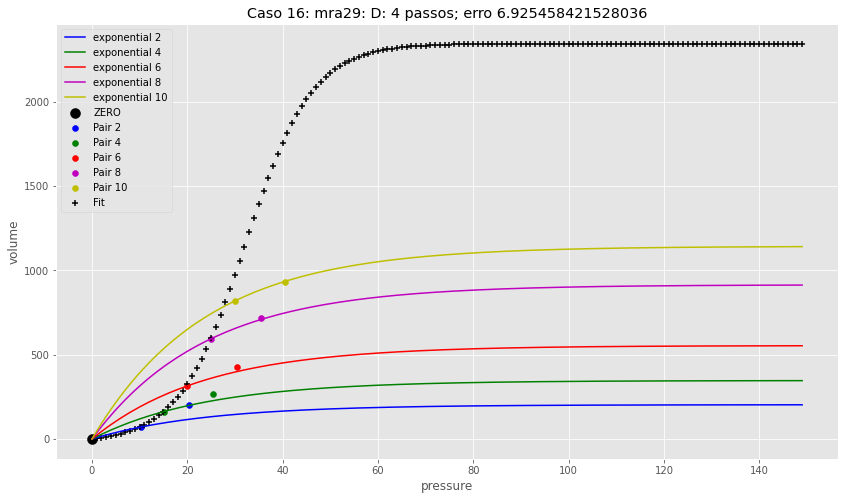

Best b: 0.205844110081041
Best zero: [0, -246.8282912345284]


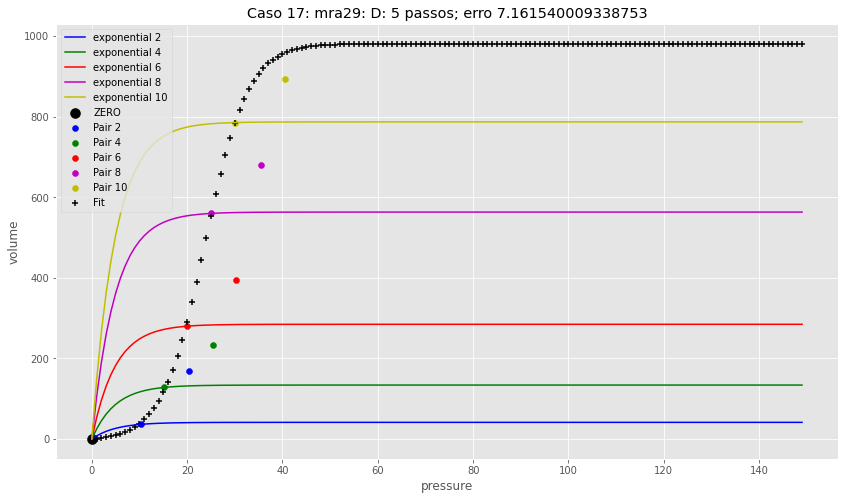

Best b: 0.003011425169930862
Best zero: [0, -314.80454423184756]


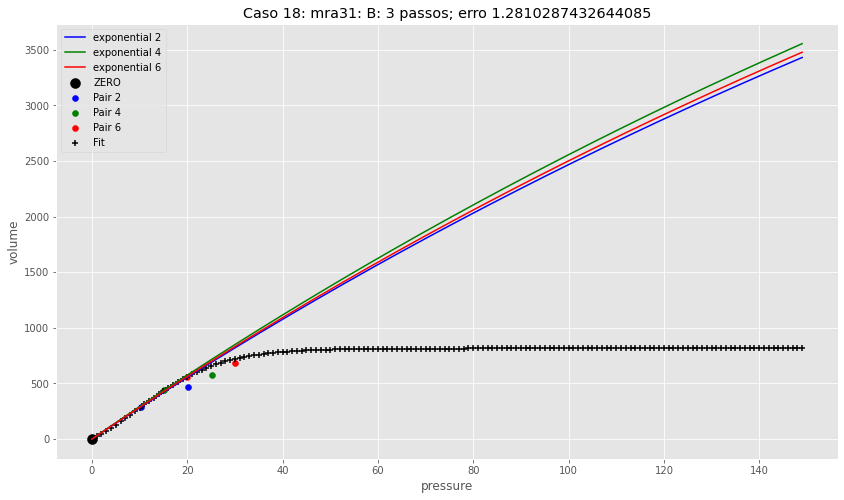

Best b: 0.0060009882201618545
Best zero: [0, -398.1327207165226]


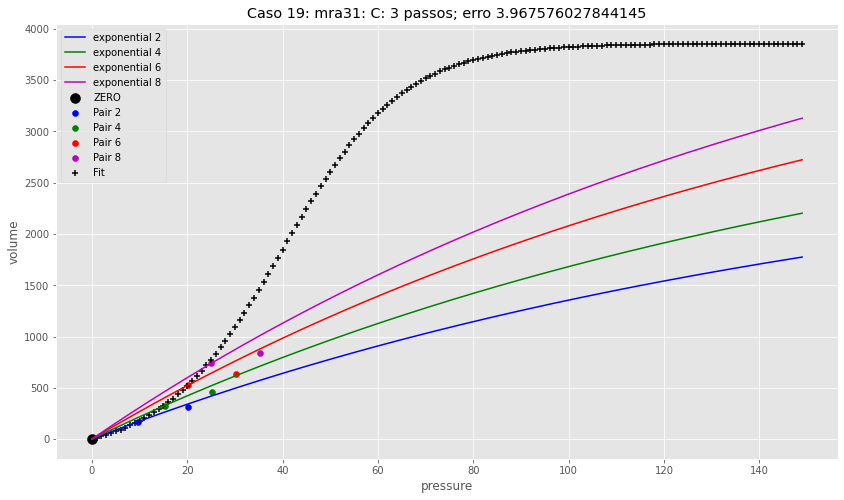

Best b: 0.015348843229600477
Best zero: [0, -364.8175580515302]


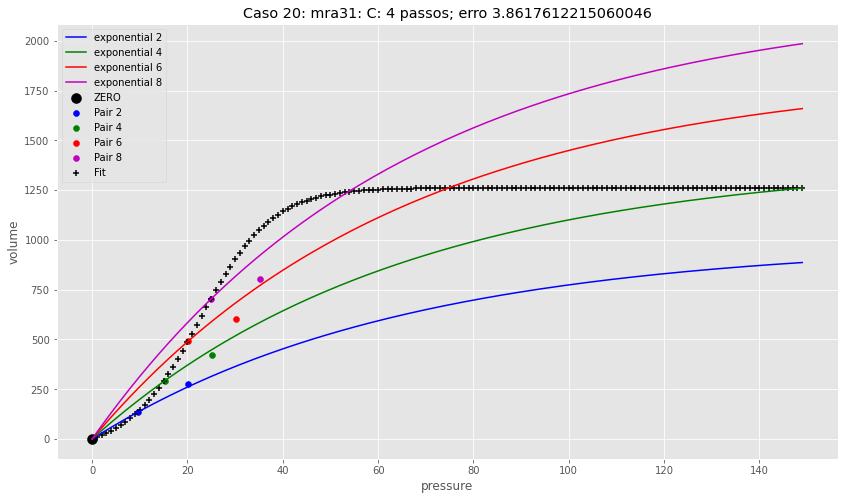

Best b: 0.0027624422844547175
Best zero: [0, -342.0276477470592]


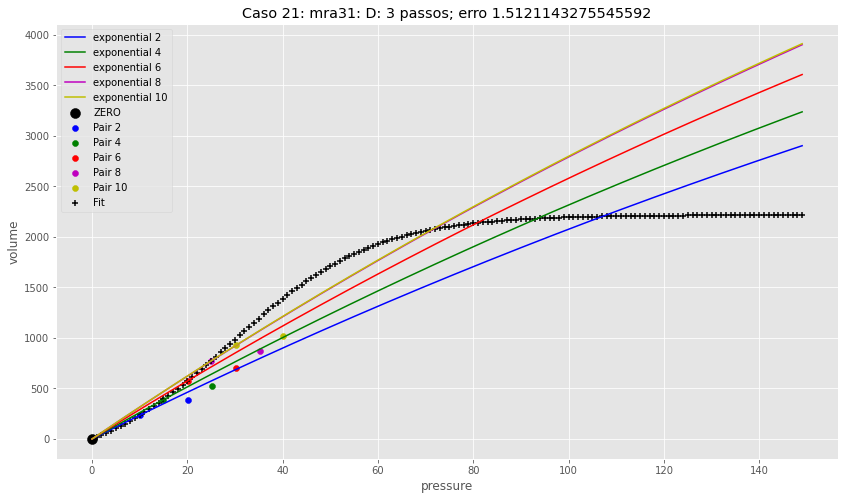

Best b: 0.0035211381355324664
Best zero: [0, -332.2753052779103]


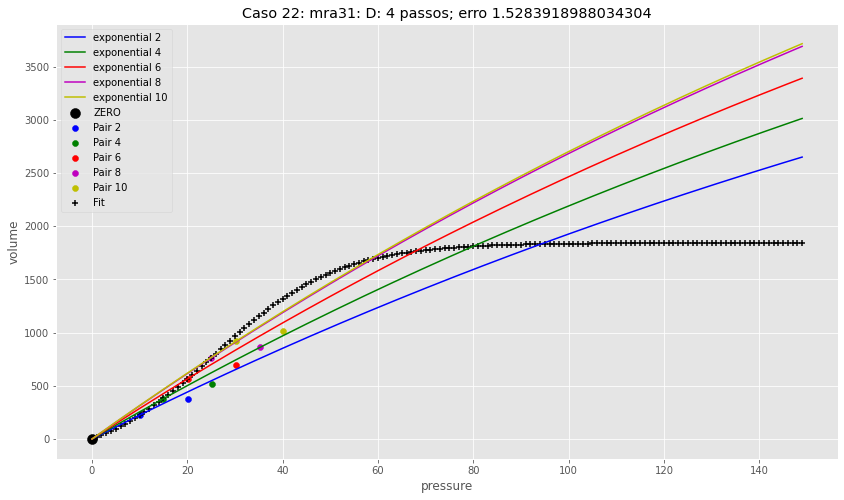

Best b: 0.013500316452885498
Best zero: [0, -269.1890495032836]


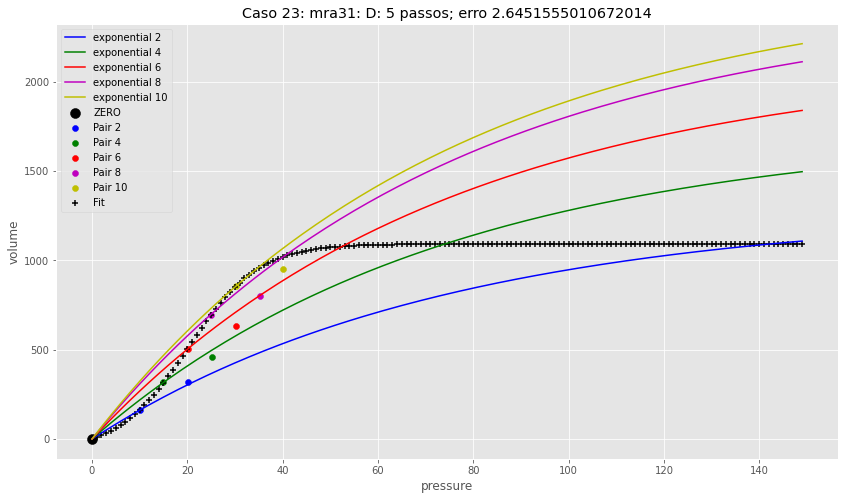

Best b: 0.007884577824182287
Best zero: [0, -175.016274760494]


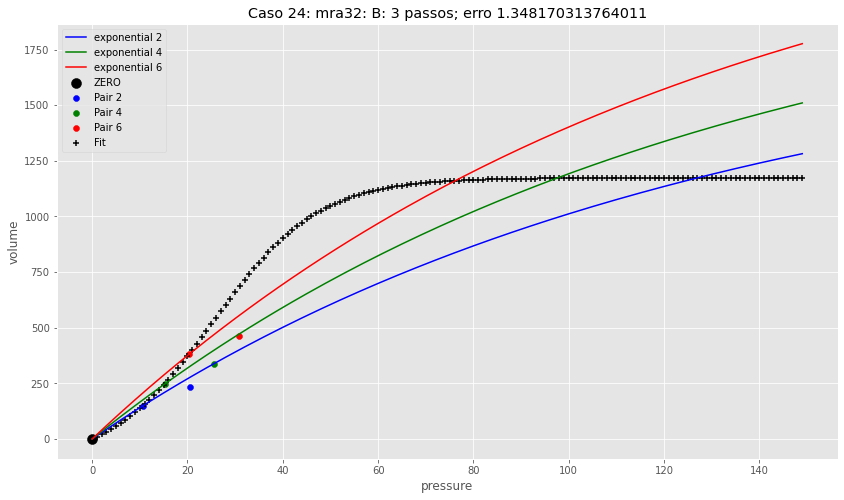

Best b: 0.004056669309772348
Best zero: [0, -253.85365071169582]


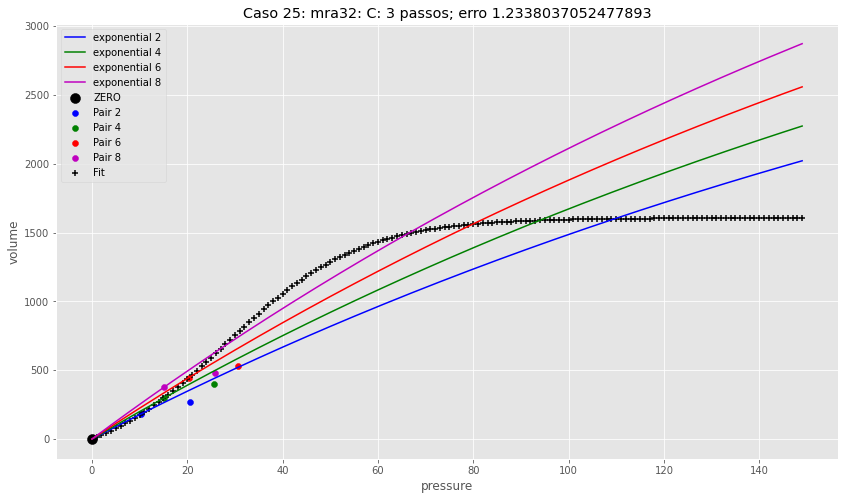

Best b: 0.004714261076609847
Best zero: [0, -631.4779491694184]


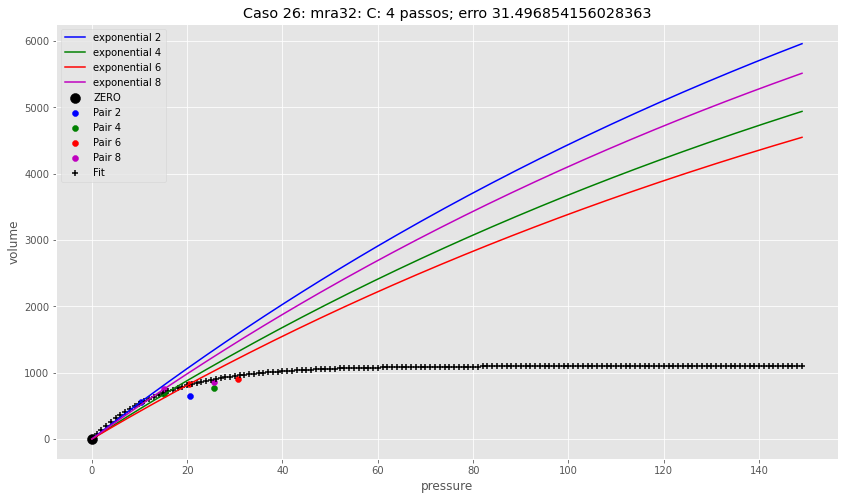

Best b: 0.05582869790008342
Best zero: [0, -131.06259258468745]


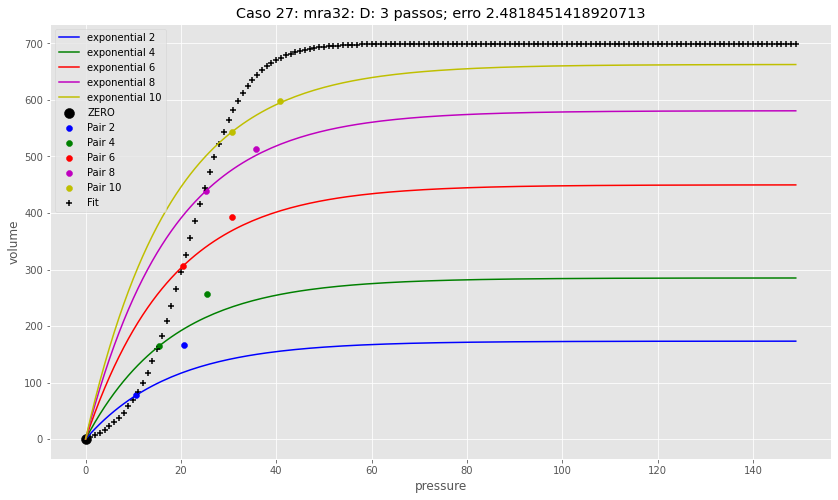

Best b: 0.06214643812785485
Best zero: [0, -130.03399809136832]


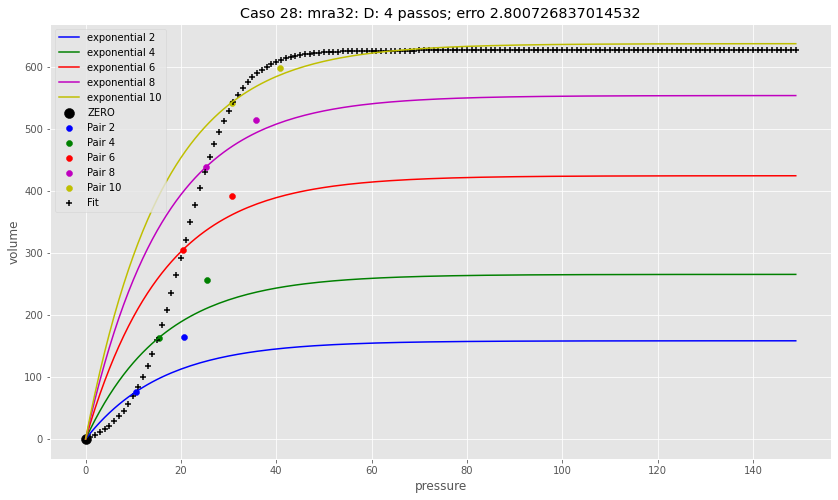

Best b: 0.06557646378676761
Best zero: [0, -129.84401158569864]


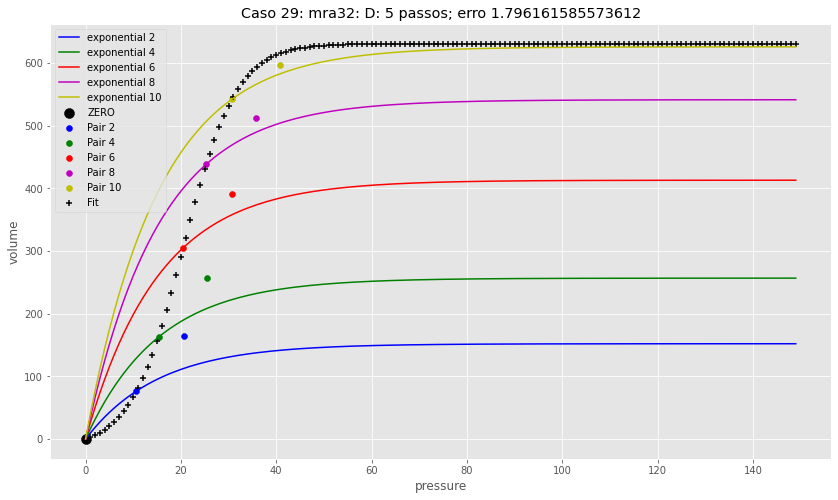

Best b: 0.00165123185453157
Best zero: [0, -191.77292599746852]


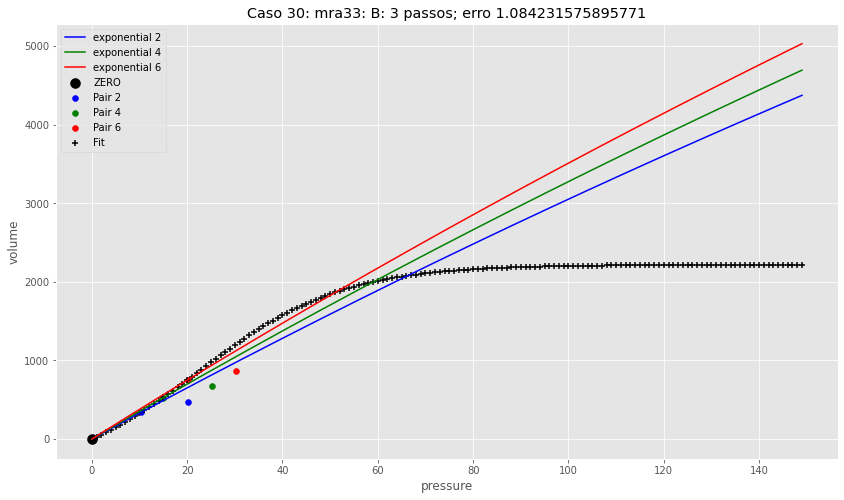

Best b: 0.006015535348229836
Best zero: [0, -273.7072067995212]


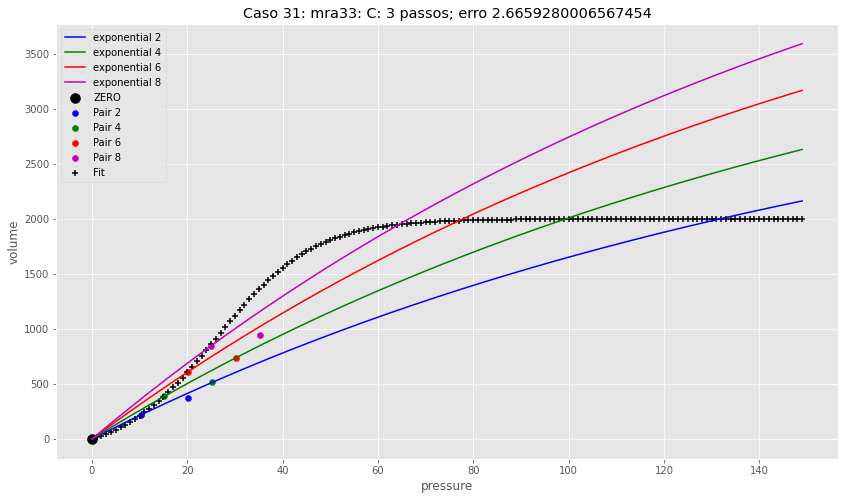

Best b: 0.00847386473503047
Best zero: [0, -257.9452947374622]


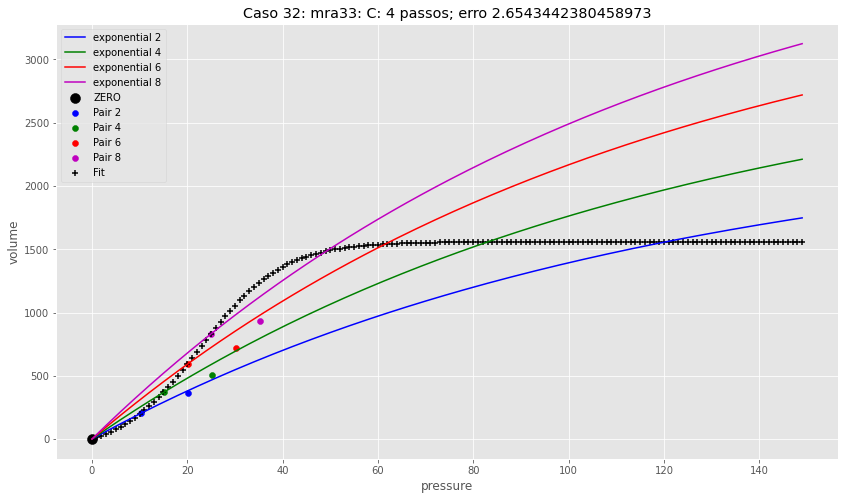

Best b: 0.00630108171743345
Best zero: [0, -321.61025905488304]


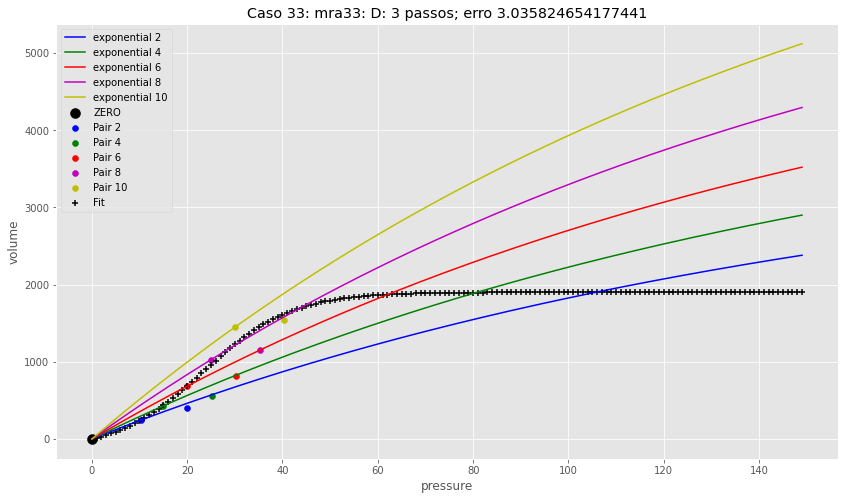

Best b: 0.0045032412232040445
Best zero: [0, -321.0033276470226]


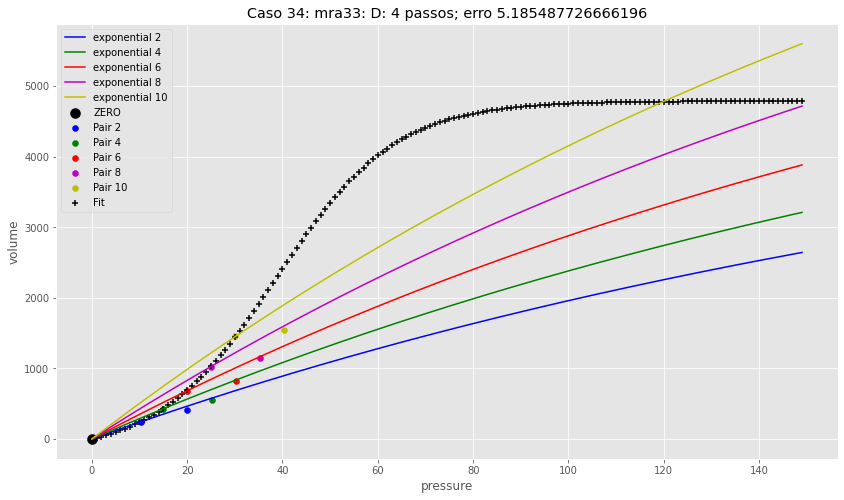

Best b: 0.004781908078727095
Best zero: [0, -317.8608996217438]


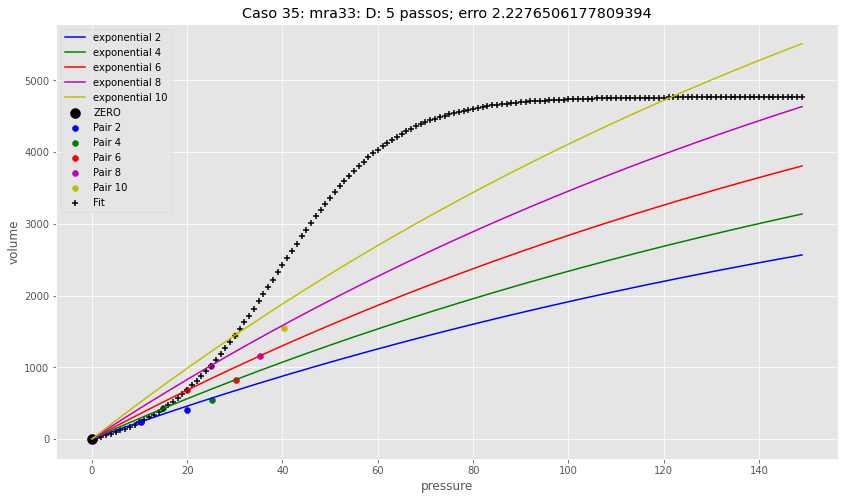

Best b: 0.0017837976985053763
Best zero: [0, -460.09772870453116]


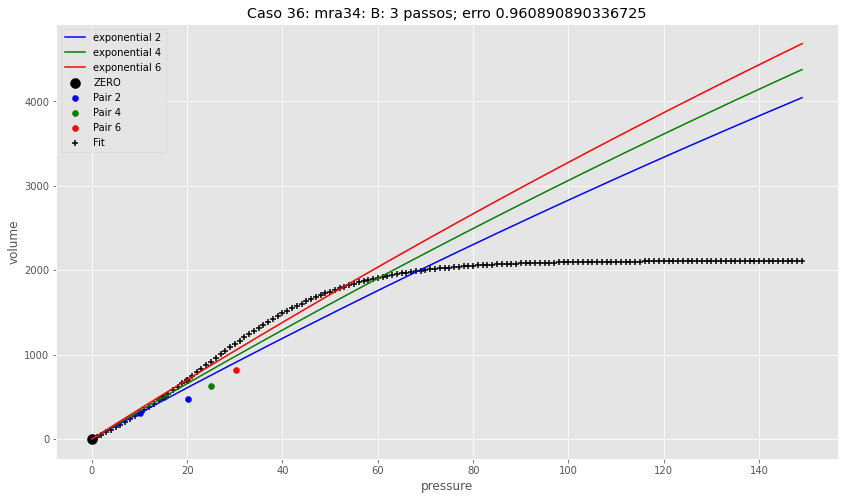

Best b: 0.004240433412886942
Best zero: [0, -495.70306247213904]


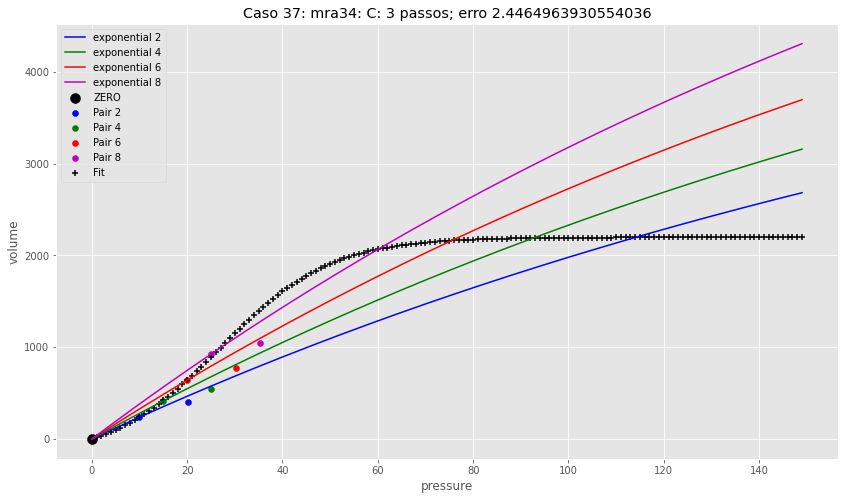

Best b: 0.003599987319705731
Best zero: [0, -491.35804471878856]


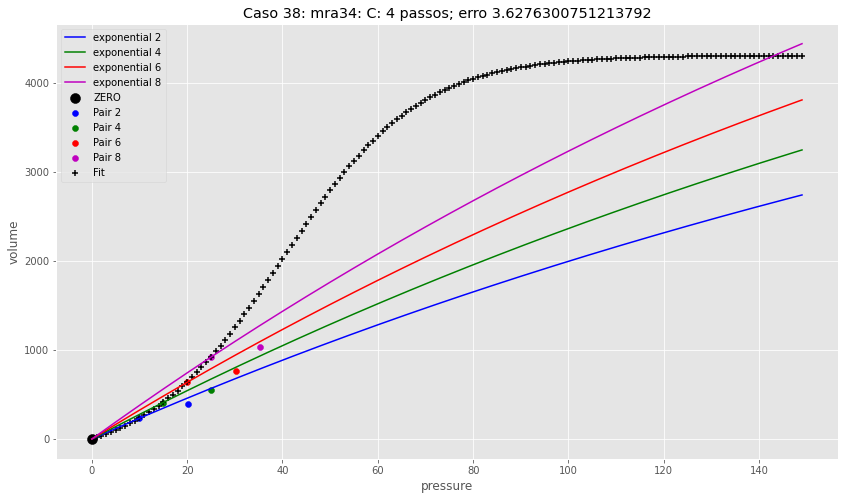

Best b: 0.0015621135719640713
Best zero: [0, -468.8688227370166]


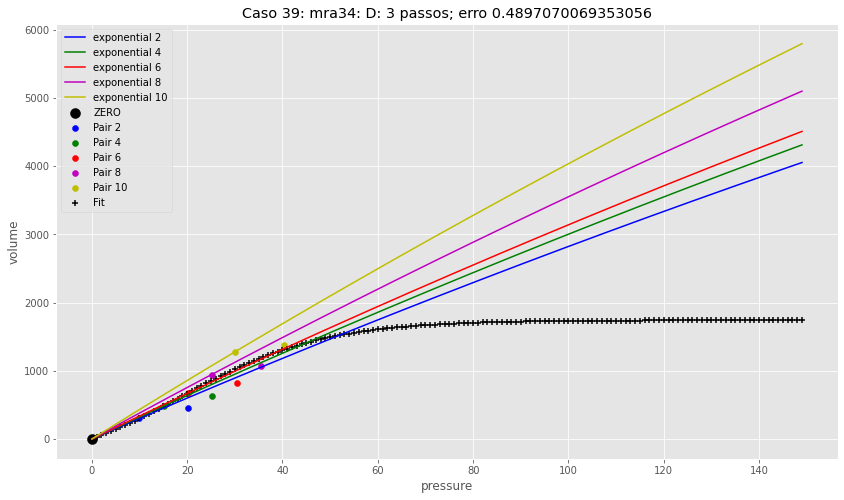

Best b: 0.003815663754377996
Best zero: [0, -375.88111458262046]


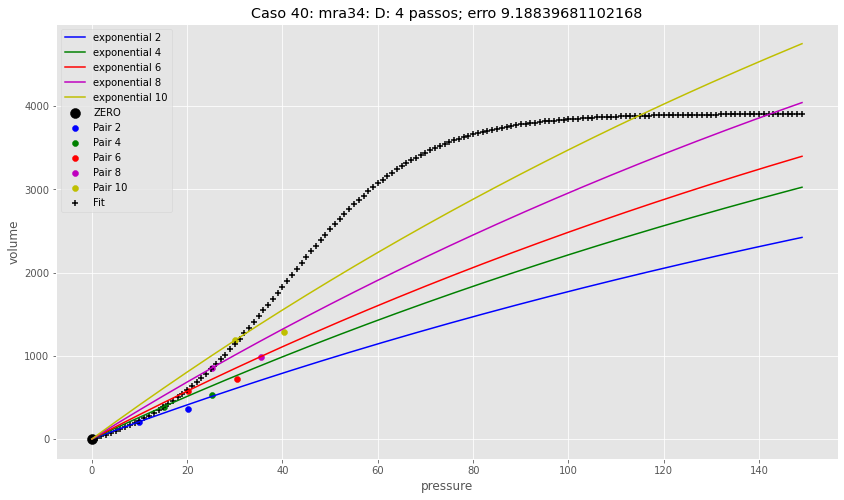

Best b: 0.0054708323929956145
Best zero: [0, -350.425729529484]


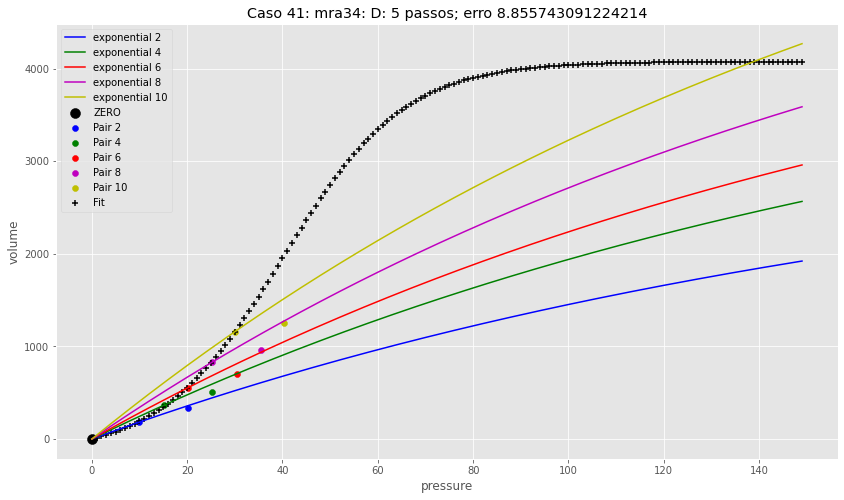

In [17]:
df_test["exponentials"] = df_test.apply(plot_exponentials, args = [exponential_cicle_fixed_b], axis=1)

In [18]:
def getMeanPoint(array, idx):
    pass
    
def test_frc_volume(ser):
    
    select_exp = 2
    
    [select_exp]
    guess_zero    = ser["guess_zero"]
    
    pressures = exponential.x
    exponential_volumes = exponential.y
    
    sigmoid_volumes   = ser["function"](pressures, *ser["param"])
    idx = np.argwhere(np.diff(np.sign(sigmoid_volumes - exponential_volumes))).flatten()
    
    plt.figure(figsize=(20,14))
    _=plt.plot(pressures, sigmoid_volumes, c = "r")
    _=plt.plot(pressures, exponential_volumes, c = "b")
    plt.scatter(pressures[idx], exponential_volumes[idx], c='k', s = 40)
    plt.scatter(raw_point[0], raw_point[1], c='g', s = 20)
    return idx

In [19]:
def get_rec_volume(raw_data, isPlot):
    pass

def get_arp_volume(exponentials, sigmoid_volumes, isPlot):
    arp_lst = []
    max_vol = sigmoid_volumes[-1]
    for exp in exponentials:
        arp_lst.append(max_vol - exp.y[-1])
        
        if isPlot:
            plt.vlines(x=exp.x[-1], ymin=exp.y[-1], ymax=max_vol, lw = 1, colors='k', linestyles = "solid")
            plt.hlines(y=exp.y[-1], xmin=0, xmax=exp.x[-1], lw = 1, colors='k', linestyles = "dashed", alpha = 0.4) 
            plt.hlines(y=max_vol, xmin=0, xmax=exp.x[-1], lw = 1, colors='k', linestyles = "dashed", alpha = 0.4) 
            plt.annotate(r"ARP", xy = (exp.x[-1], max_vol), weight="bold")
            
    return arp_lst

def get_irv_volume(exponentials, snd_raw_data, isPlot):
    
    irv_lst = []
    for exp, snd_raw in zip(exponentials, snd_raw_data):
        
        irv_lst.append(exp.y[-1] - snd_raw[1])
        
        if isPlot:
            plt.vlines(x=exp.x[-1], ymin=snd_raw[1], ymax=exp.y[-1], lw = 1, colors='k', linestyles = "solid")
            plt.hlines(y=snd_raw[1], xmin=snd_raw[0], xmax=exp.x[-1], lw = 1, colors='k', linestyles = "dashed") 
            plt.annotate(r"IRV", xy = (exp.x[-1], exp.y[-1]), weight="bold")
            
    return irv_lst

def get_vt_volume(raw_data, isPlot):
    
    vt_lst = []
    for fst_raw, snd_raw in zip(raw_data[::2], raw_data[1::2]):
        
        x1, y1 = fst_raw
        x2, y2 = snd_raw
        vt_lst.append(y2 - y1)
    
        if isPlot:
            plt.hlines(y=y1, xmin=x1, xmax=x2, lw = 1, colors='k', linestyles = "dashed")
            plt.vlines(x=x2, ymin=y1, ymax=y2, lw = 1, colors='k', linestyles = "solid")
            plt.annotate(r"VT", xy = (x2, y2), weight="bold")
        
    return vt_lst

def get_frc_volume(guess_zero_y, fst_raw_data, isPlot):    
    
    frc_lst = []
    
    for raw_x, raw_y in fst_raw_data:
        
        if isPlot:
            plt.vlines(x=raw_x, ymin=guess_zero_y, ymax=raw_y, lw = 1, colors='k', linestyles = "solid")
            plt.annotate(r"FRC", xy = (raw_x, raw_y), weight="bold")
            
        frc_lst.append(raw_y - guess_zero_y)
    
    return frc_lst

def get_volumes(ser, isPlot):
    
    raw_data        = ser["raw_data"]
    fst_raw_data    = ser["raw_data"][::2]
    snd_raw_data    = ser["raw_data"][1::2]
    guess_zero      = ser["guess_zero"]
    exponentials    = ser["exponentials"]
    
    colors = ["r","m","y","b","g","c"]
    plt.figure(figsize = (20,8))
    
    init_raw_x = raw_data[0][0]
    init_raw_y = raw_data[0][1]
    
    if np.array(list(isPlot.values())).any(): 
        sigmoid_volumes   = ser["function"](exponentials[-1].x, *ser["param"])
        plt.scatter(exponentials[-1].x, sigmoid_volumes, c = "c", marker = "+", label = "Sigmoid")
        for idx, (c, exp, fst_raw, snd_raw) in enumerate(zip(colors, exponentials, raw_data[::2], raw_data[1::2])):
            plt.scatter(fst_raw[0], fst_raw[1], c = c, marker = ".", s = 60)
            plt.scatter(snd_raw[0], snd_raw[1], c = c, marker = ".", s = 60)
            plt.plot(exp.x, exp.y,  c=c, lw=2)
            
    try:
        frc_lst = get_frc_volume(guess_zero[1], fst_raw_data, isPlot["FRC"])
    except:
        frc_lst = []
        
    try:
        vt_lst = get_vt_volume(raw_data, isPlot["VT"])
    except:
        vt_lst = []
    
    #try:
    irv_lst = get_irv_volume(exponentials, snd_raw_data, isPlot["IRV"])
    #except:
    #    irv_lst = []
        
    try:
        arp_lst = get_arp_volume(exponentials, sigmoid_volumes, isPlot["ARP"])
    except:
        arp_lst = []
        
    plt.legend()
    plt.show()
    
    return frc_lst, vt_lst, irv_lst, arp_lst


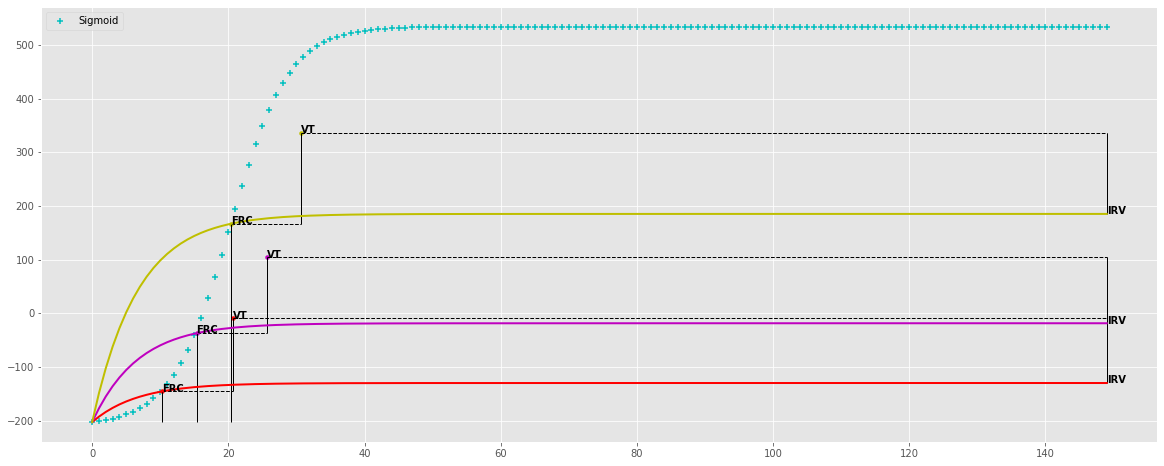

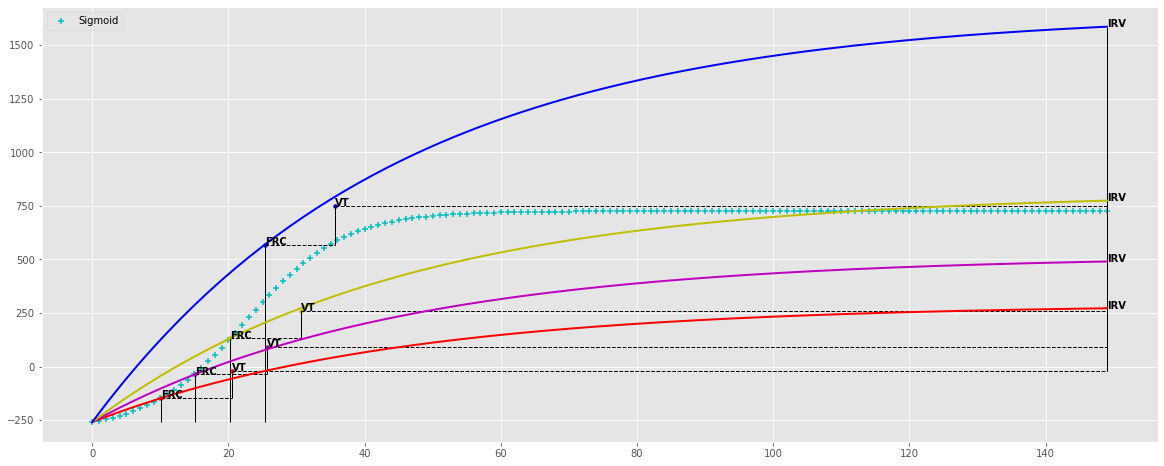

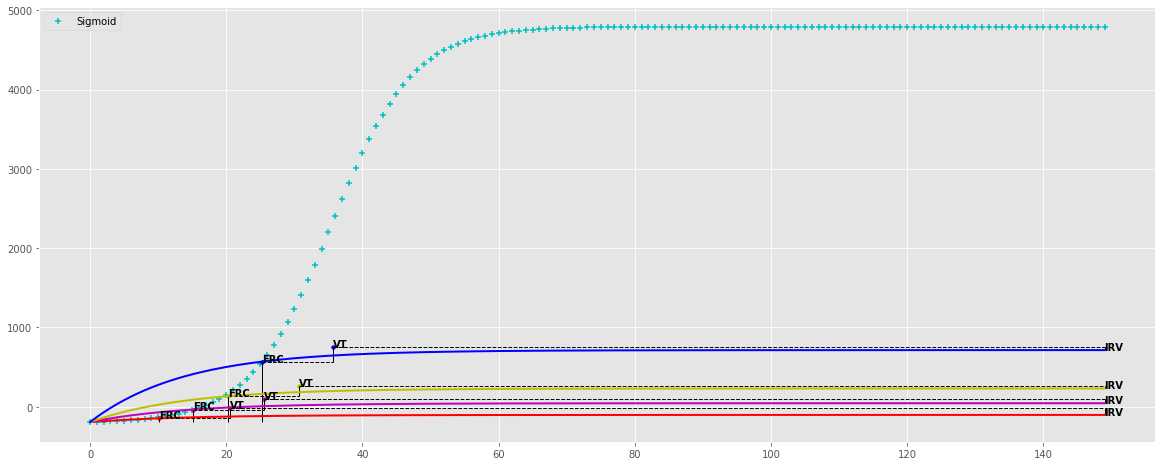

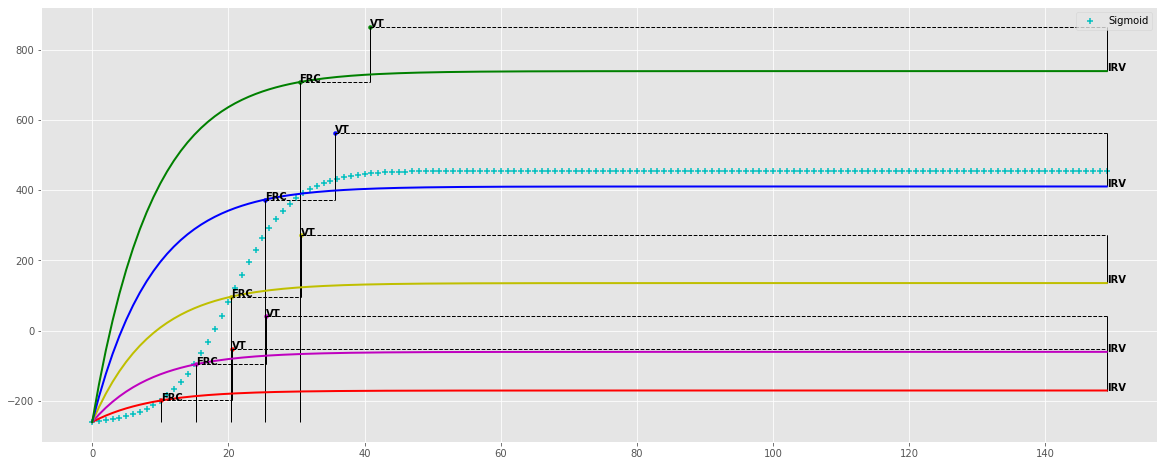

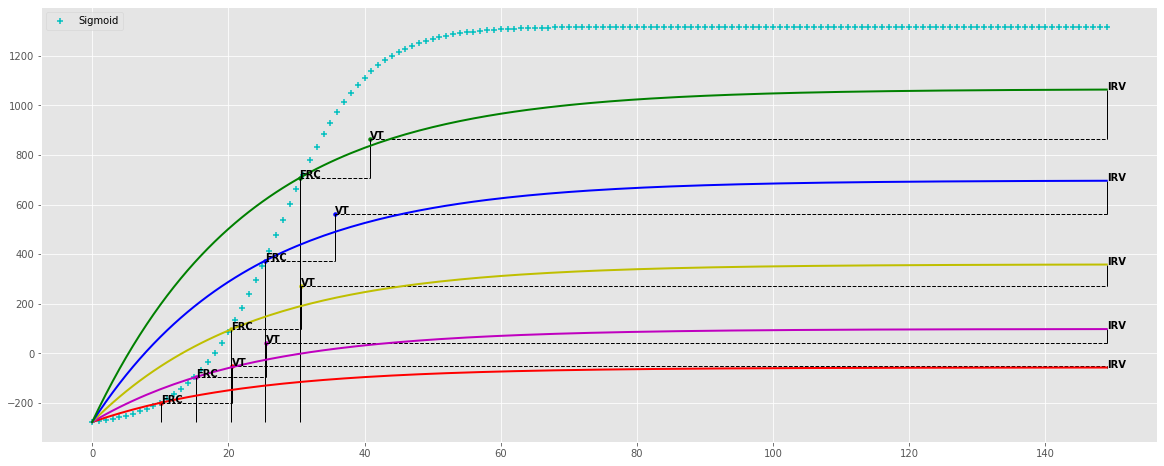

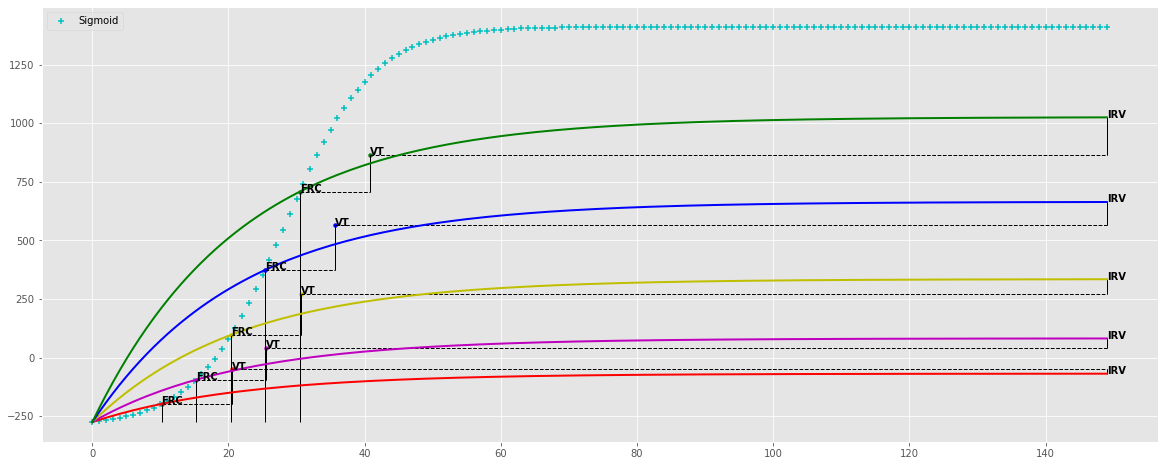

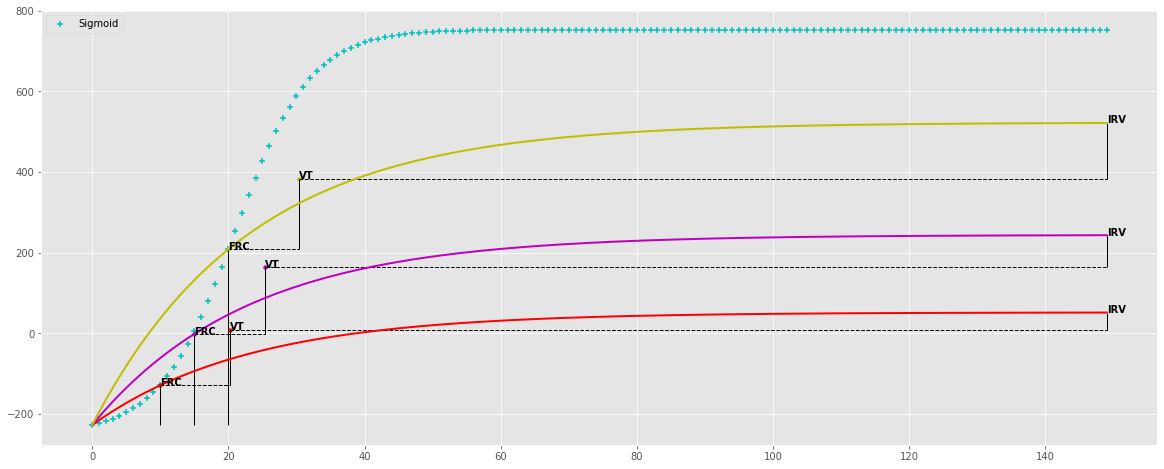

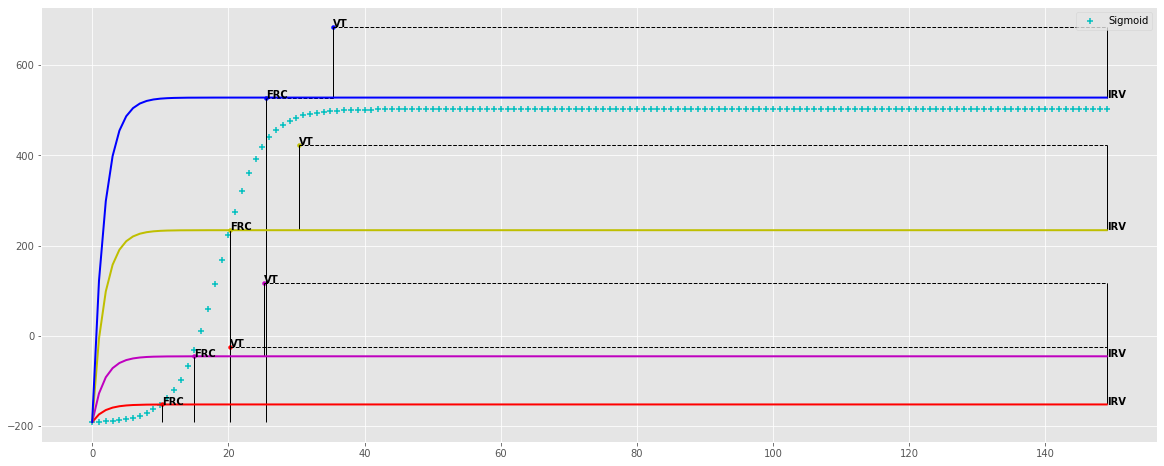

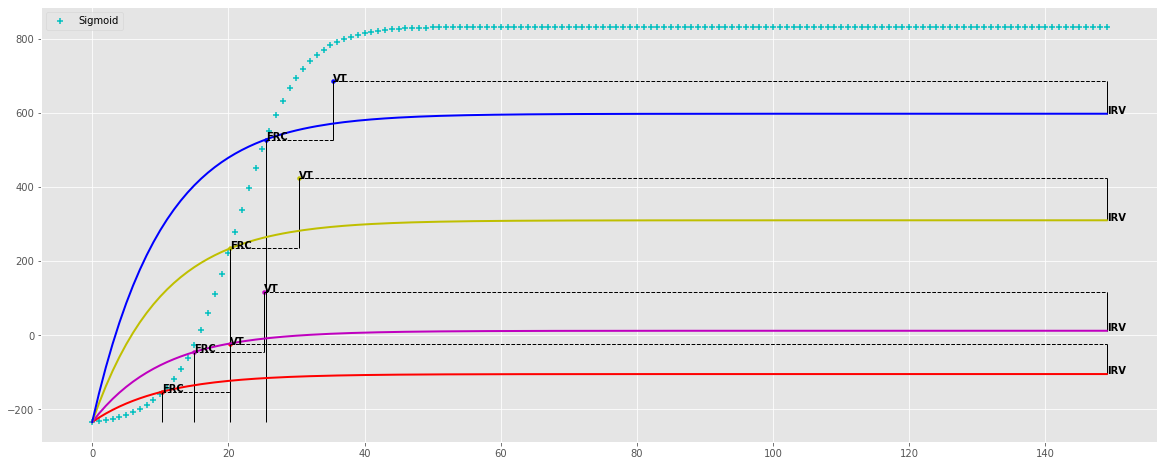

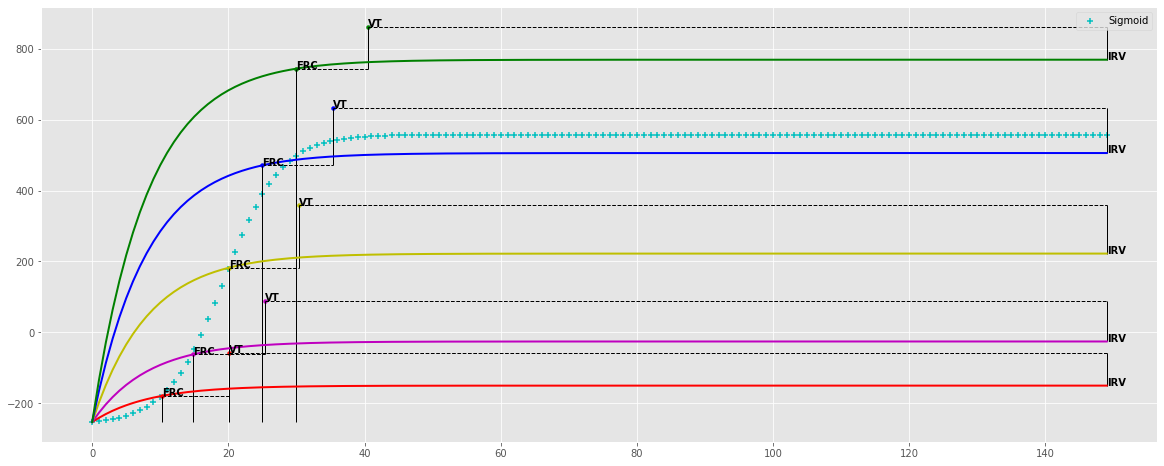

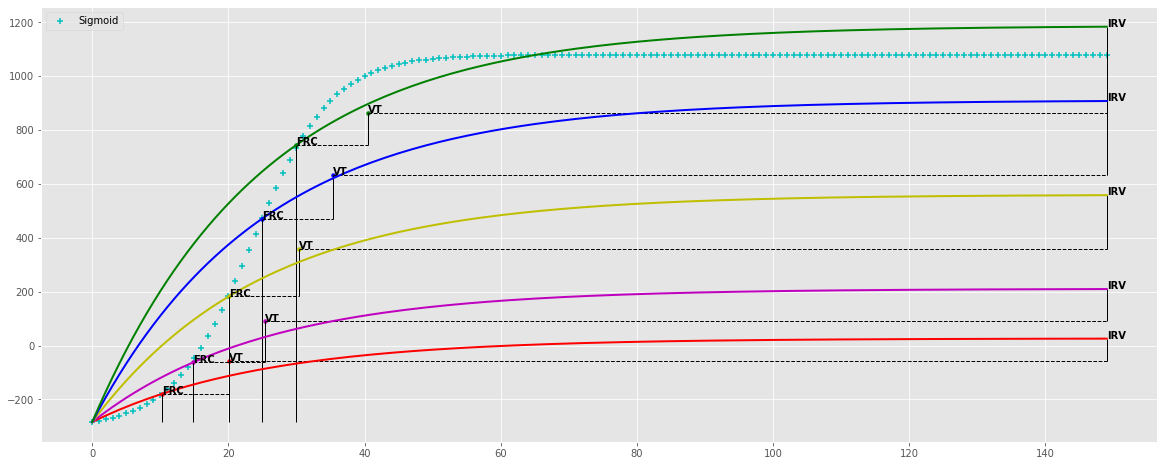

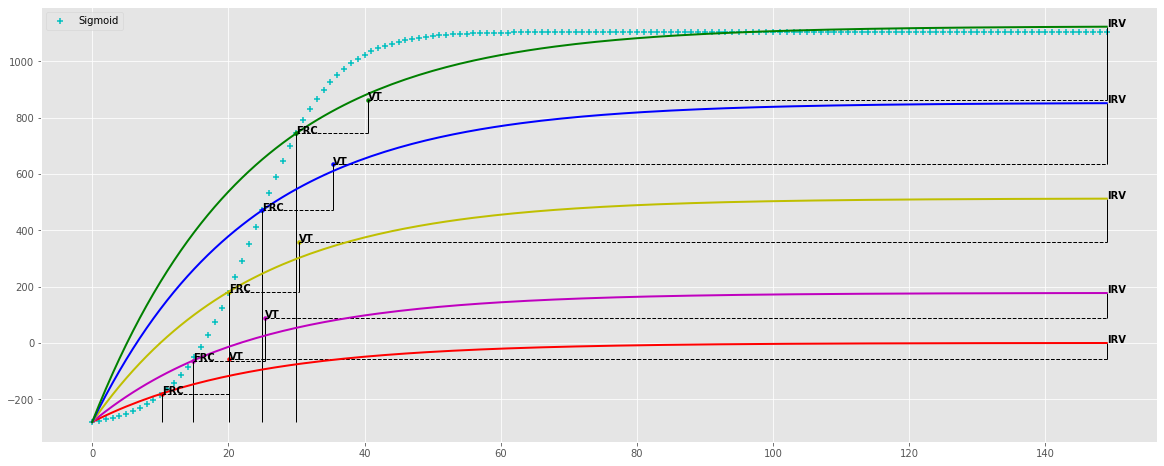

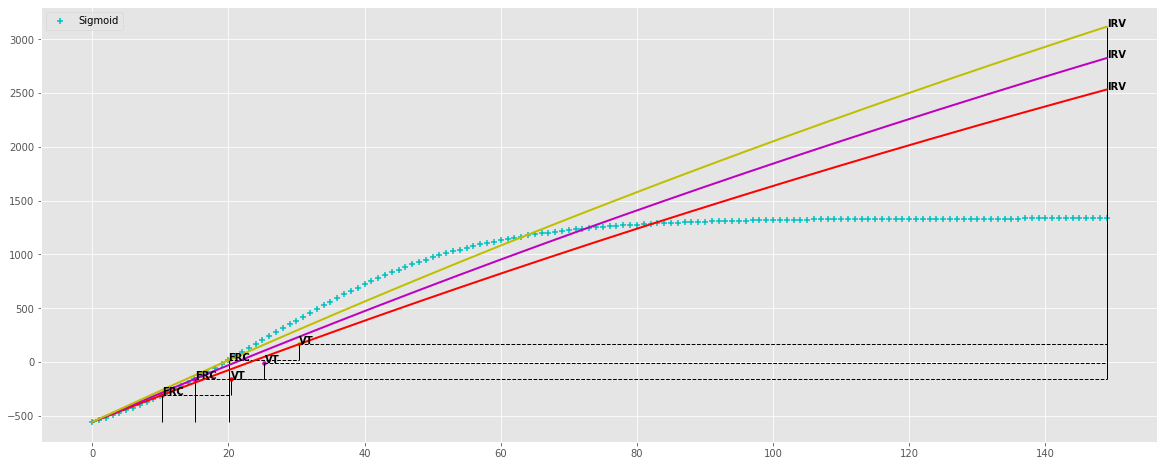

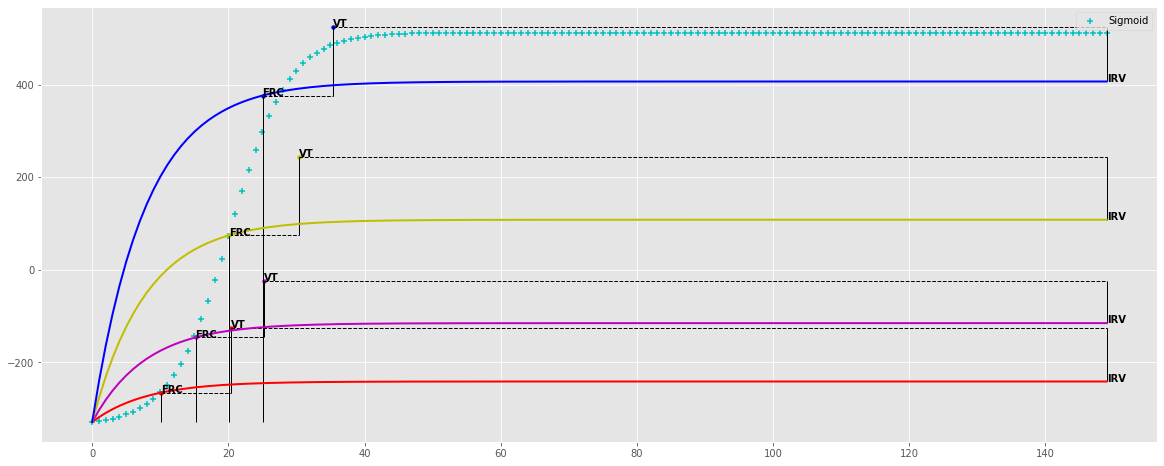

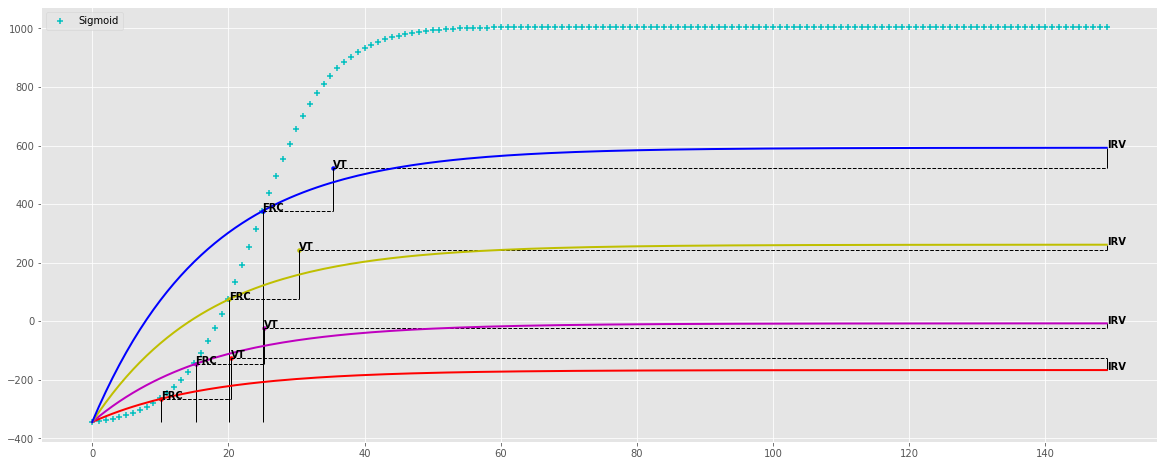

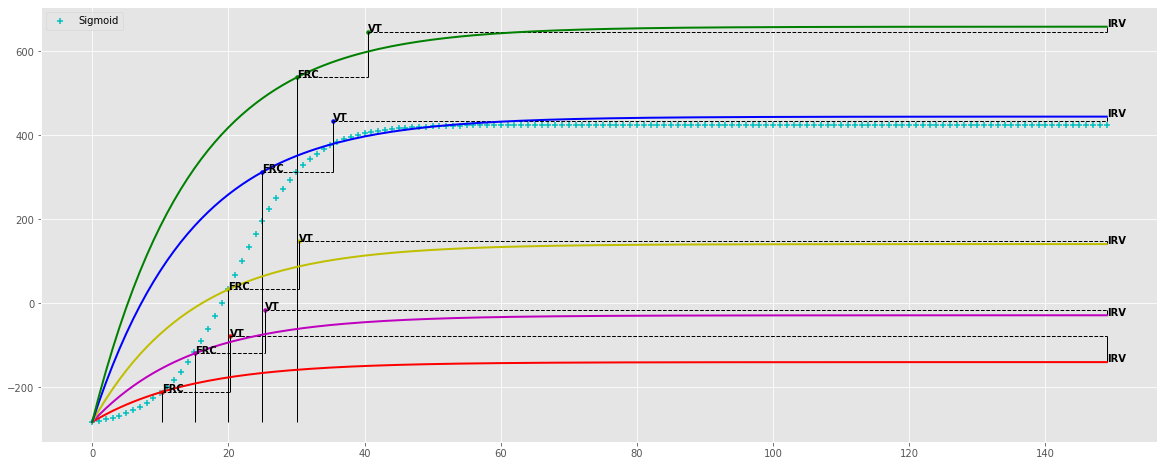

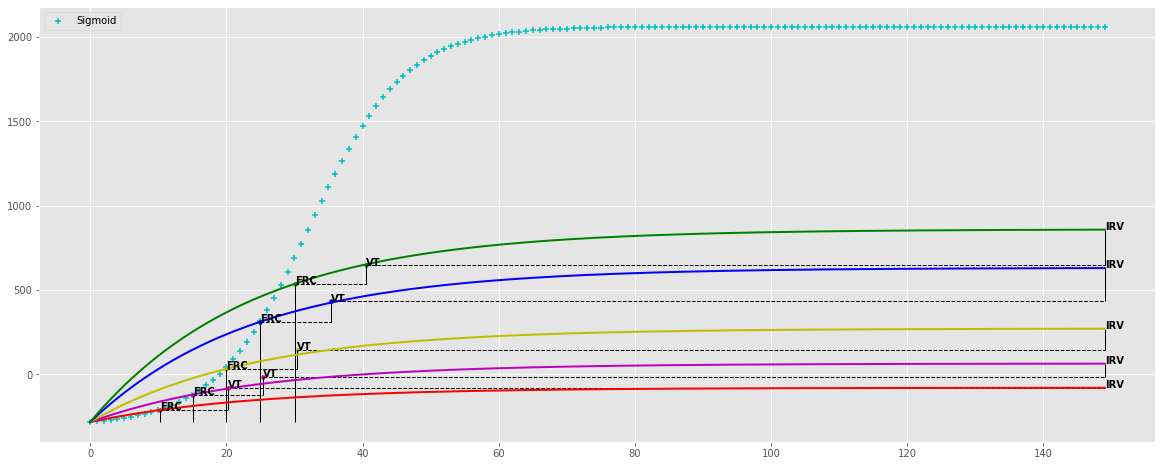

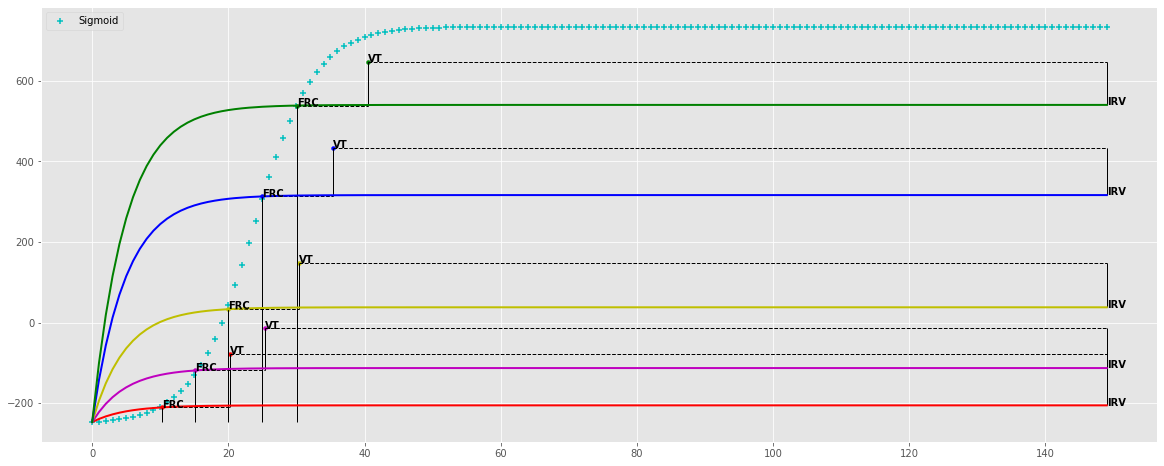

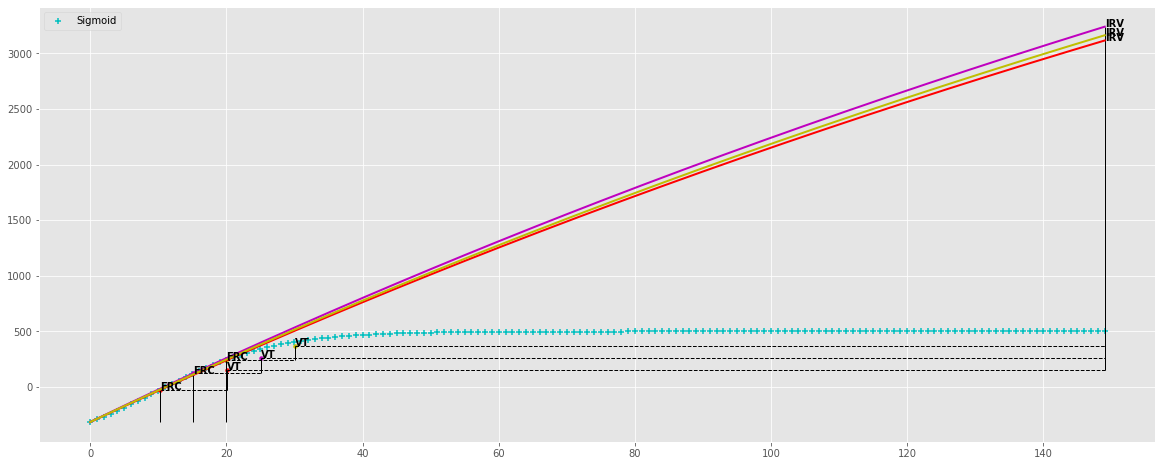

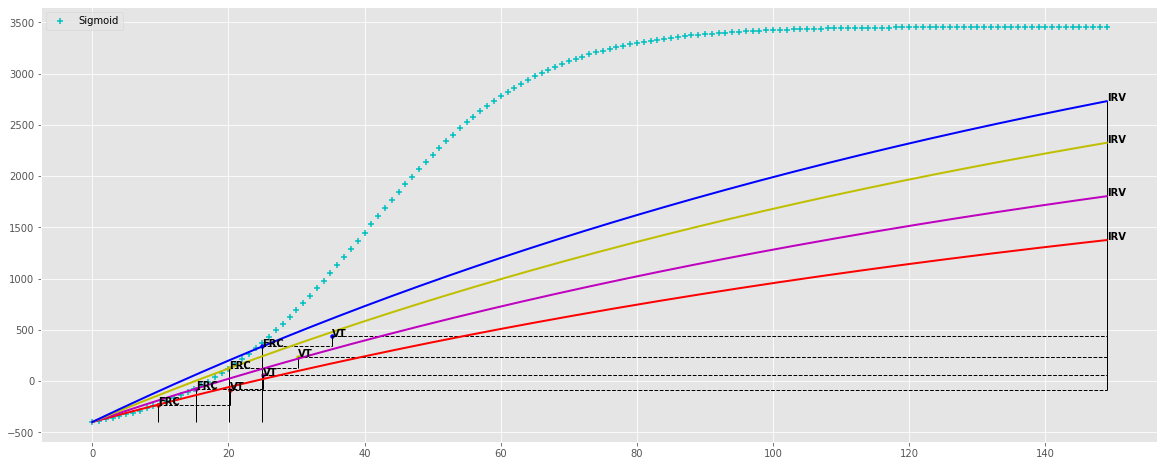

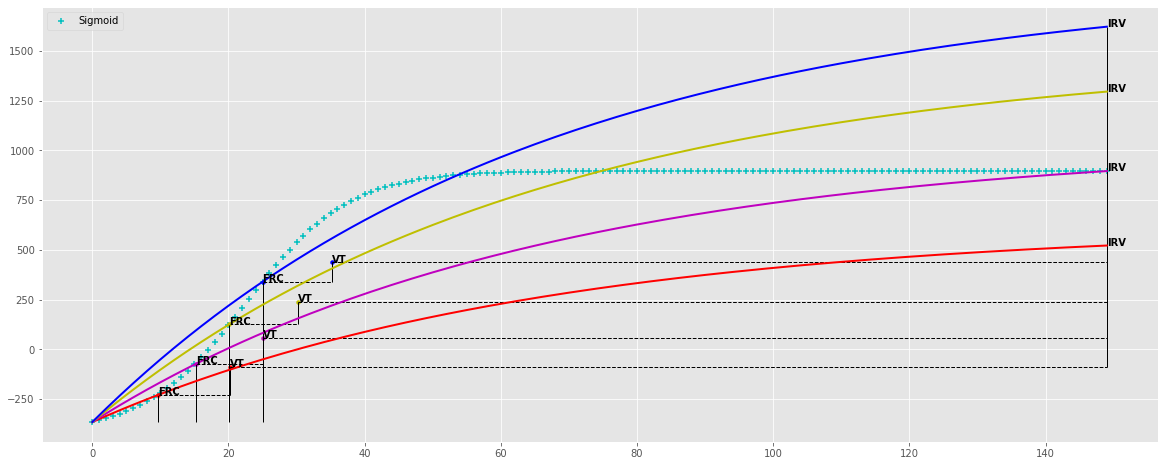

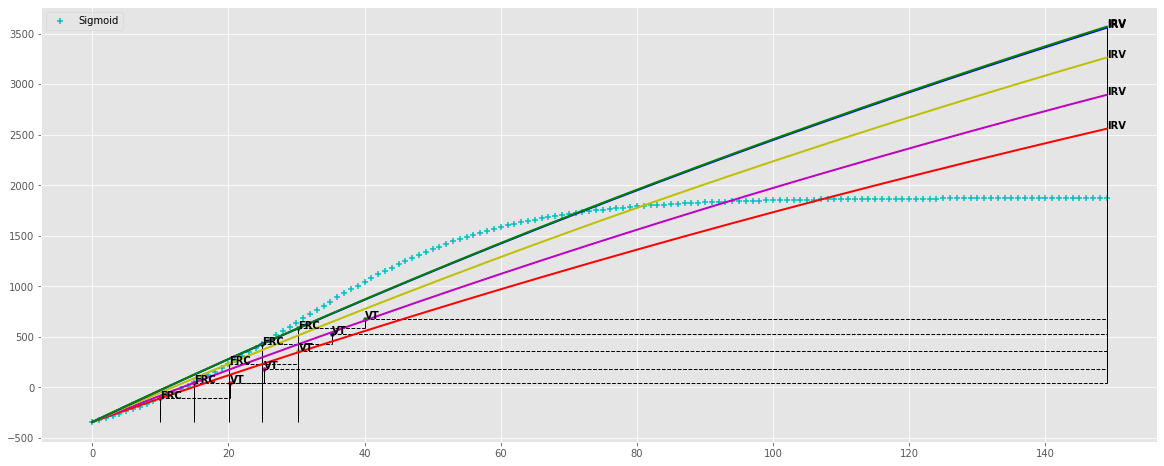

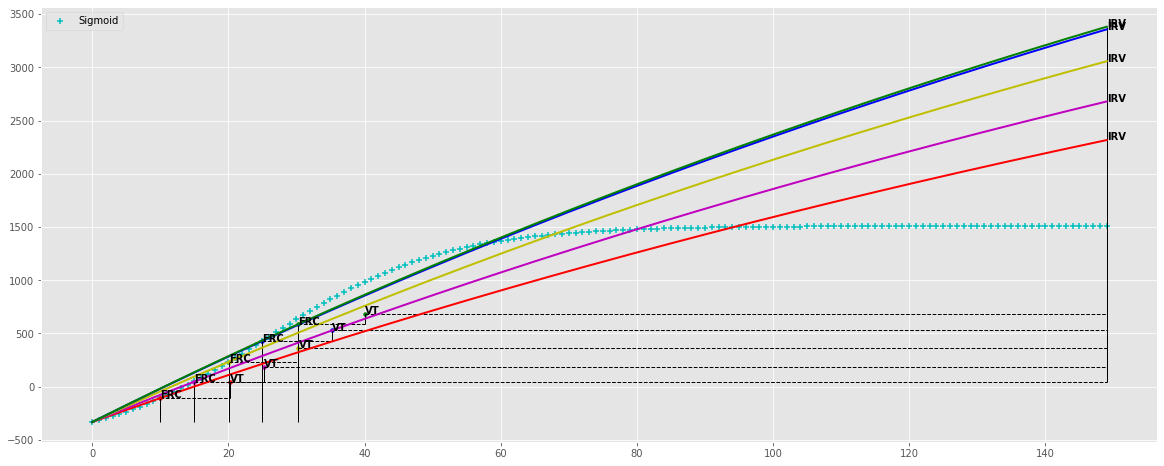

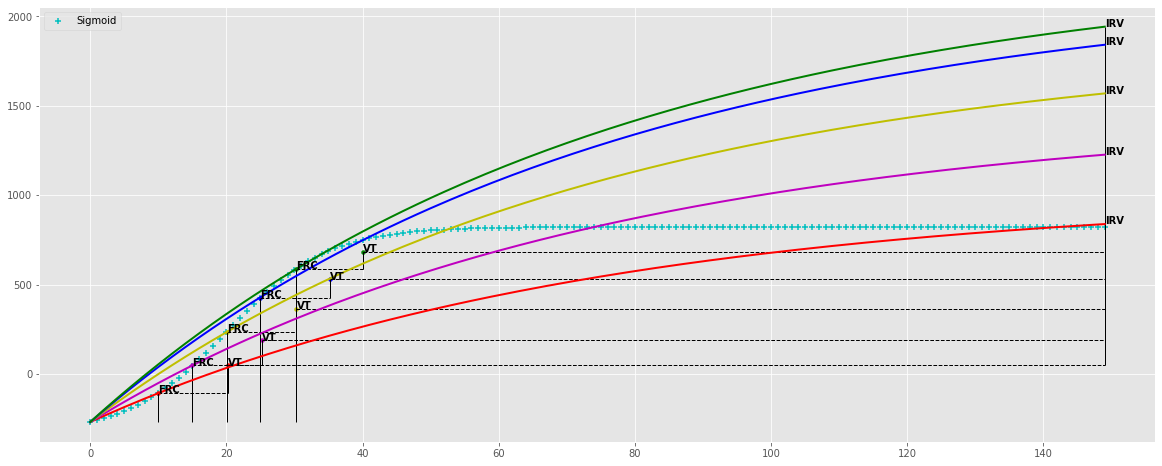

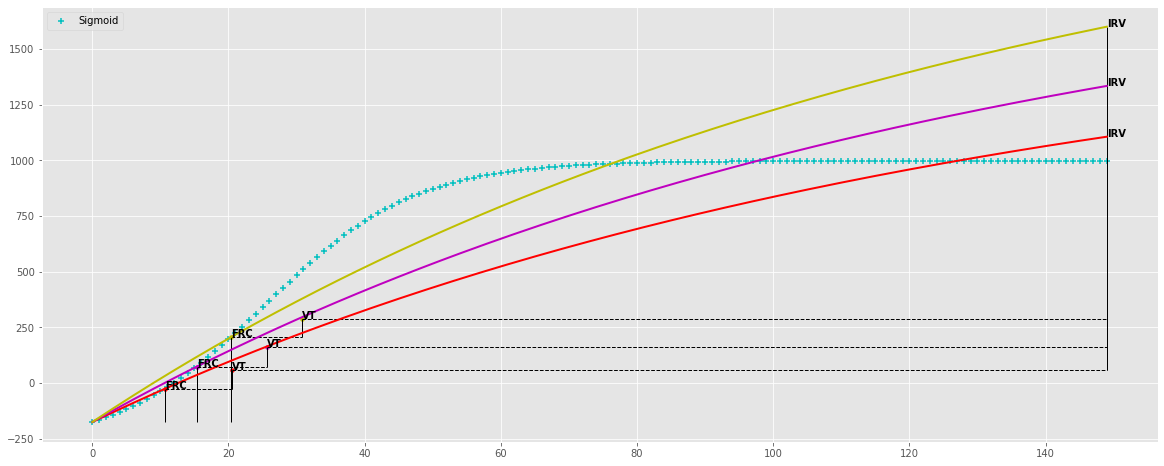

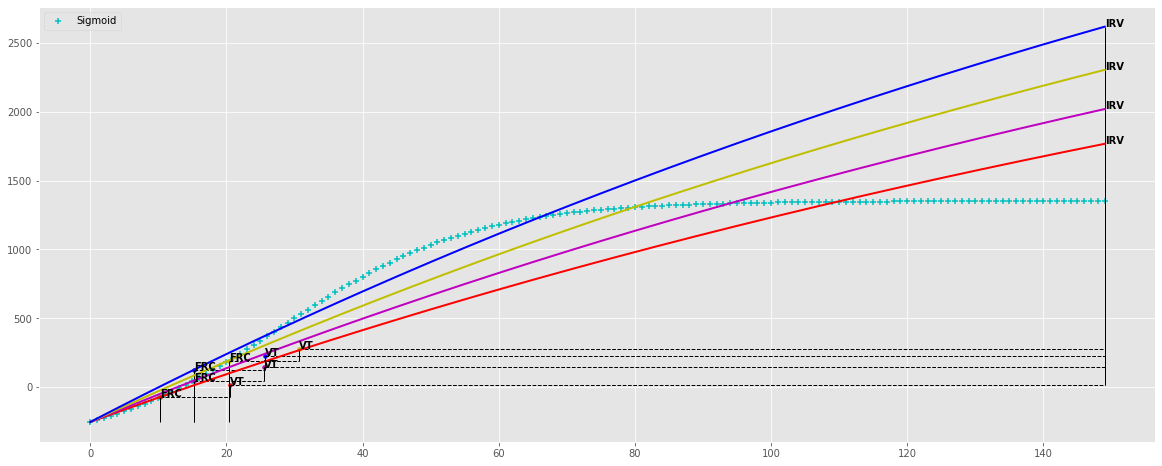

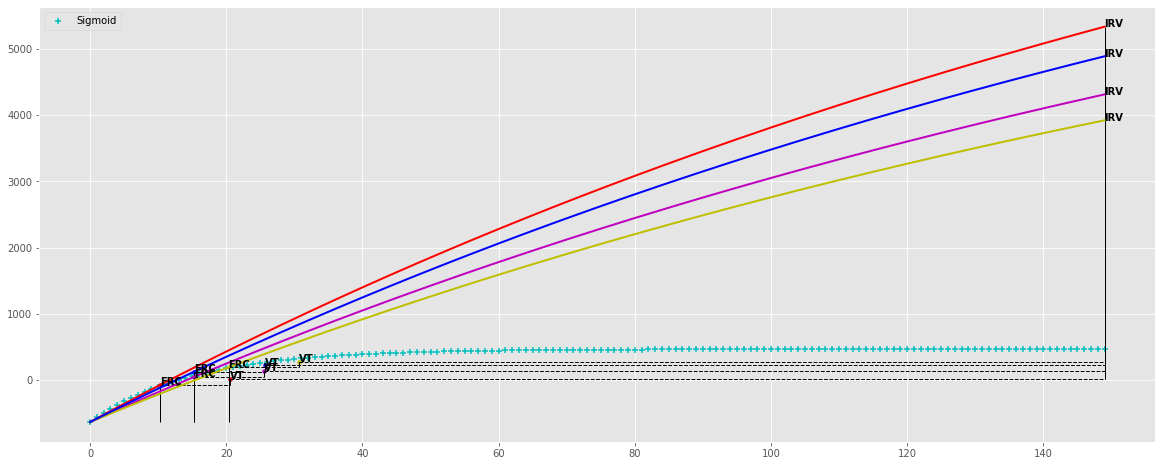

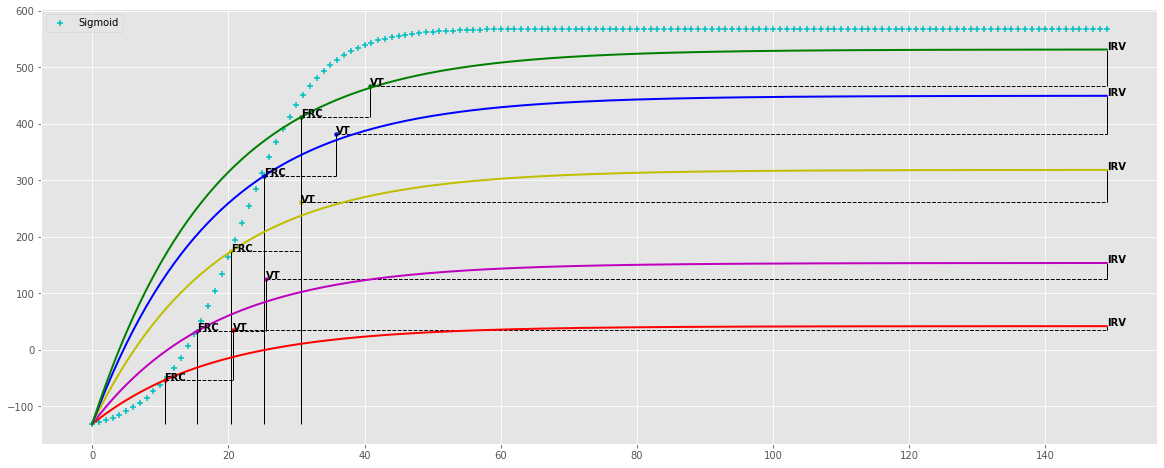

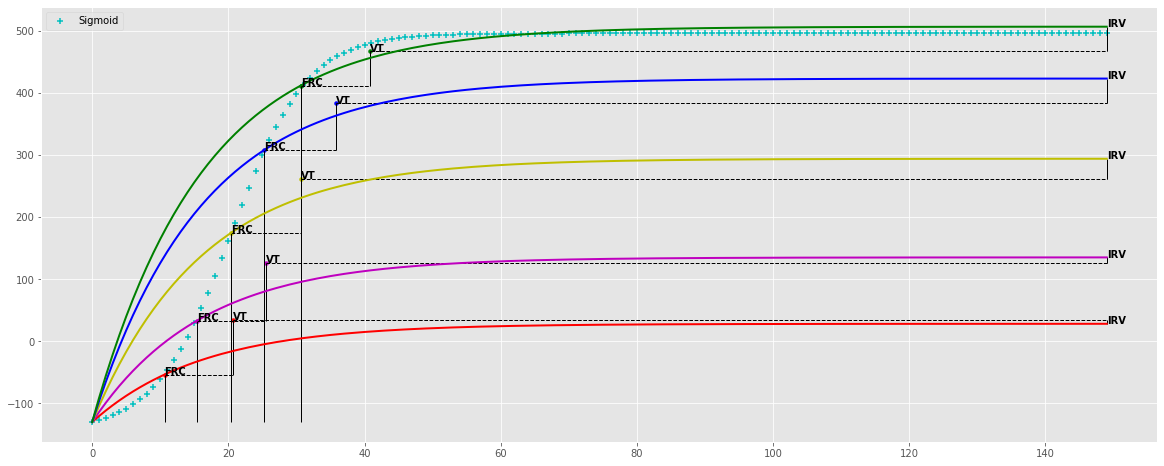

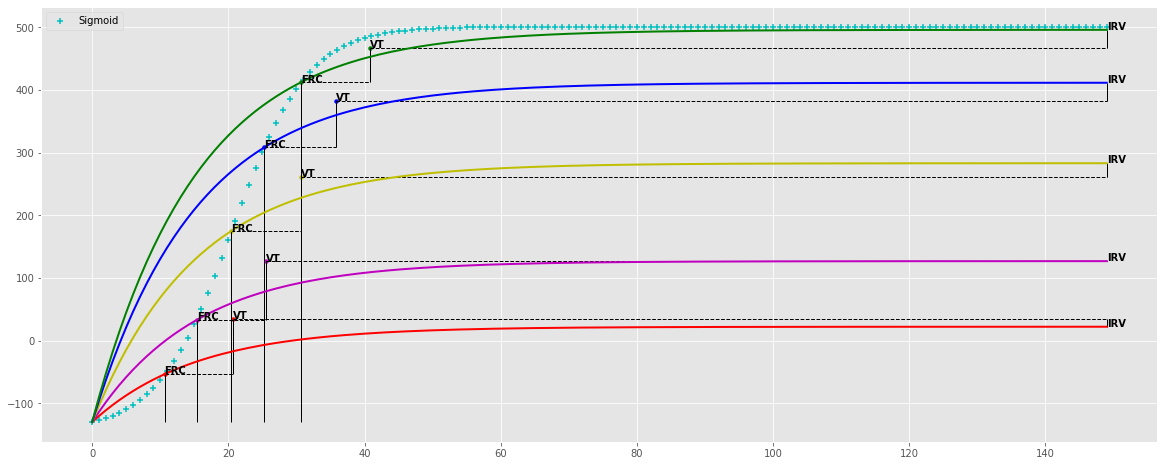

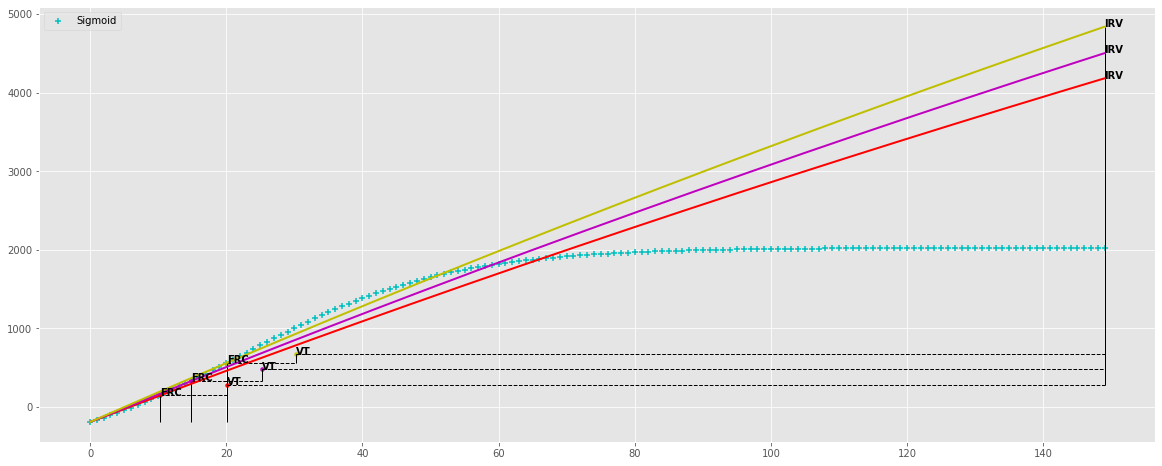

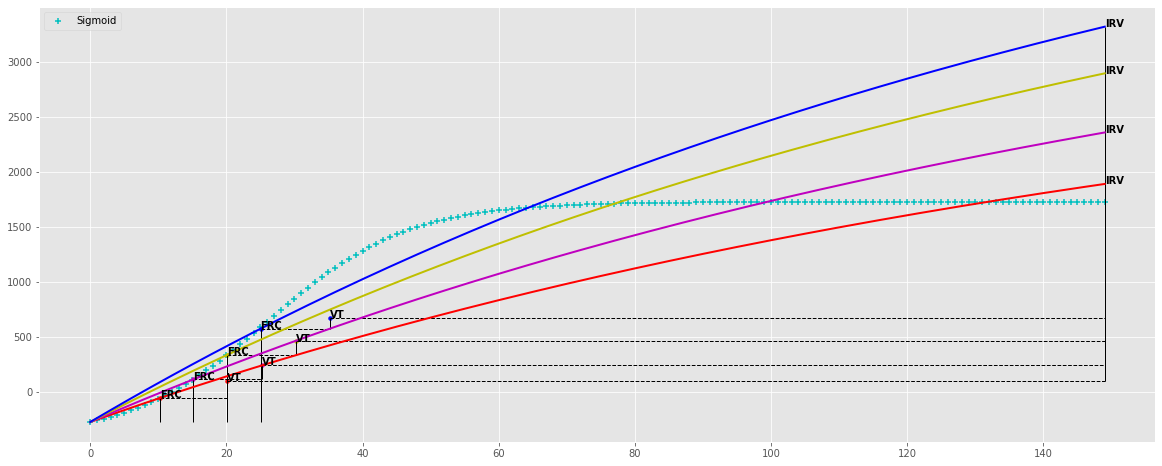

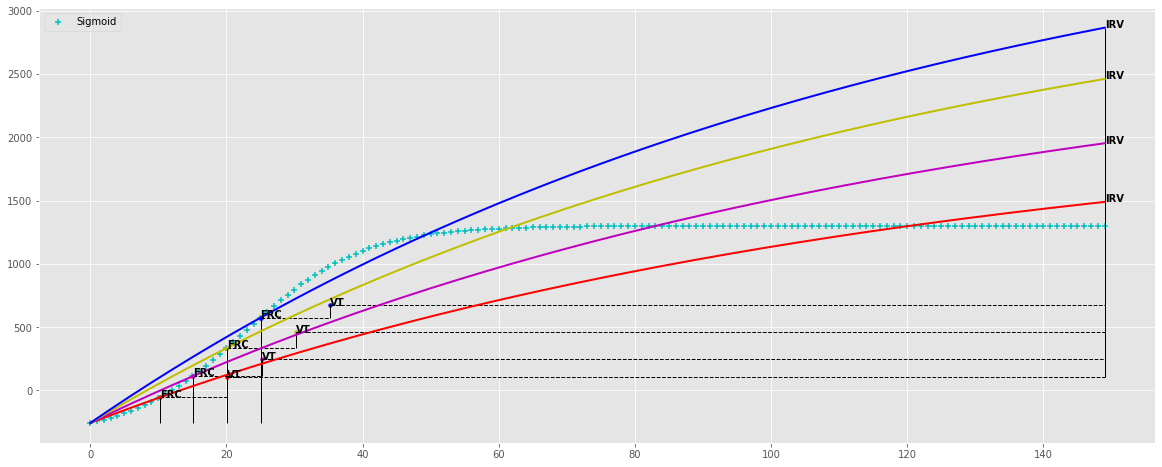

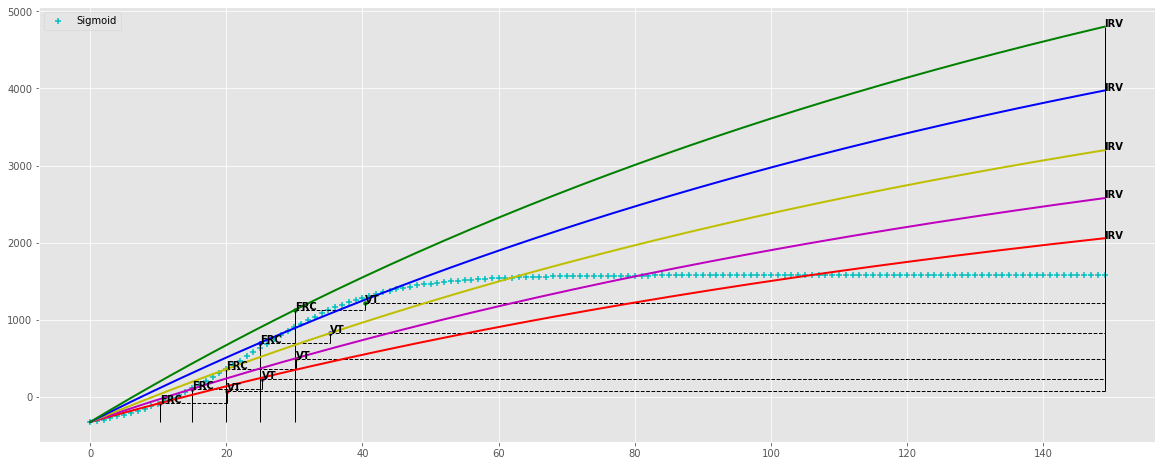

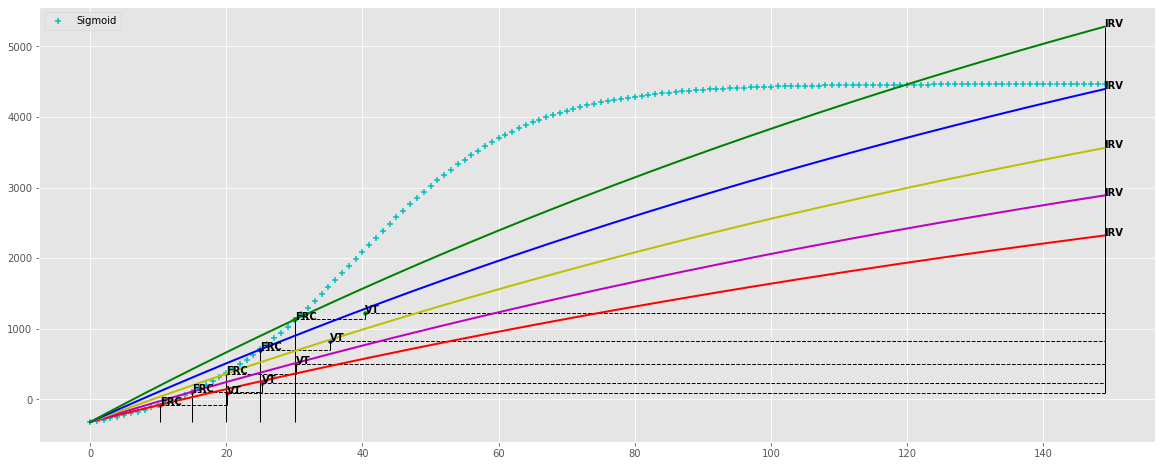

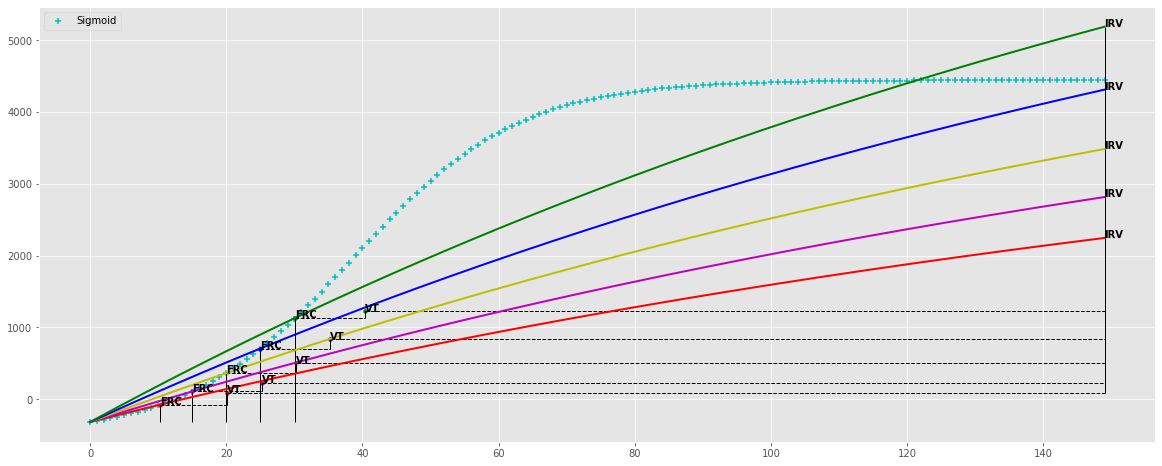

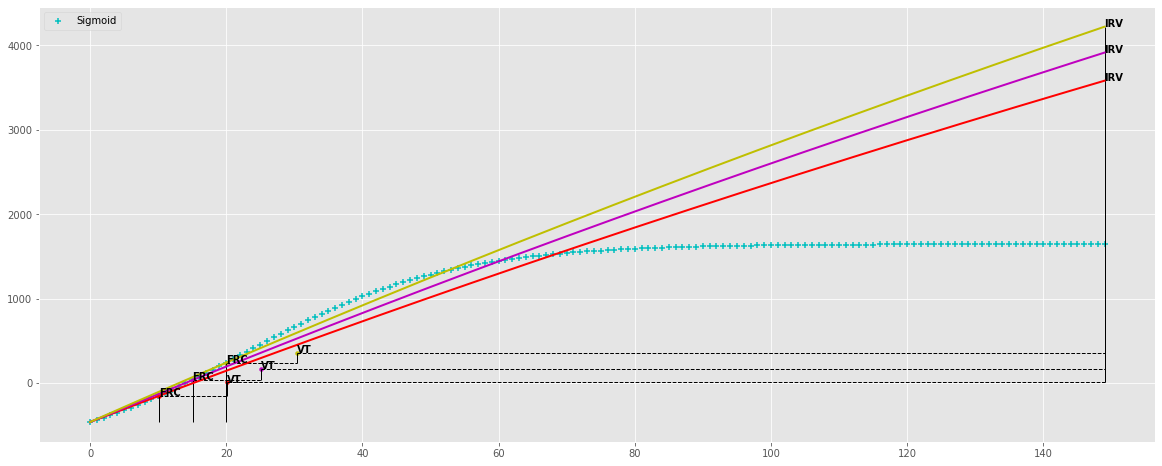

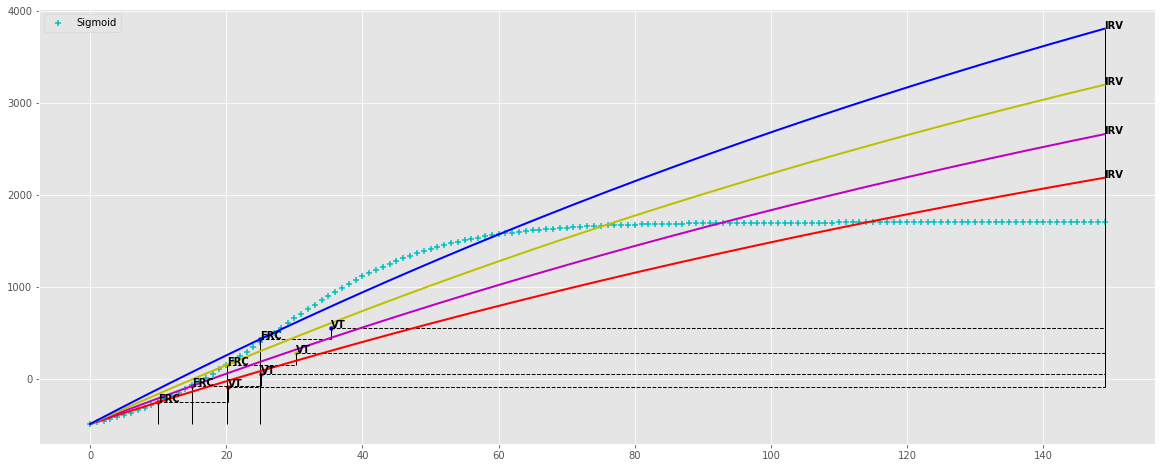

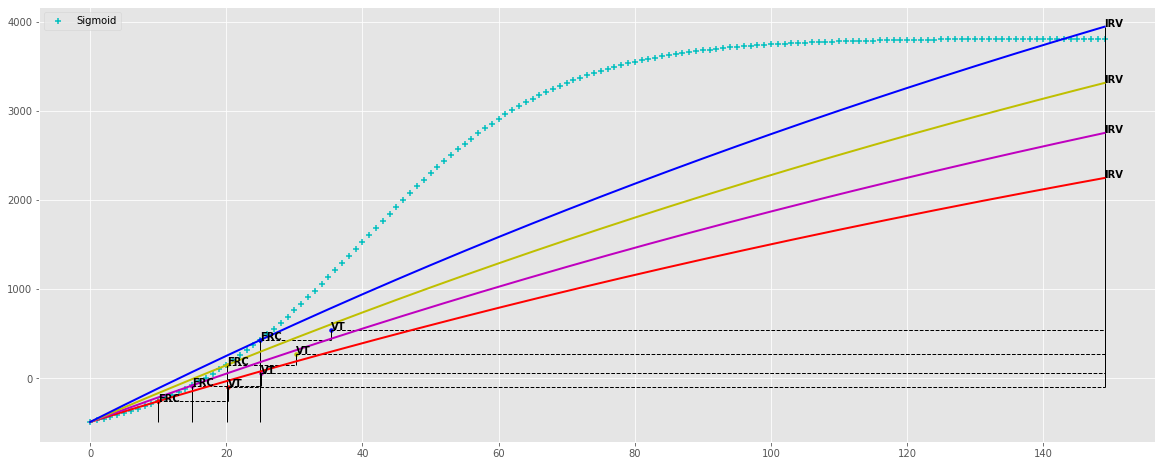

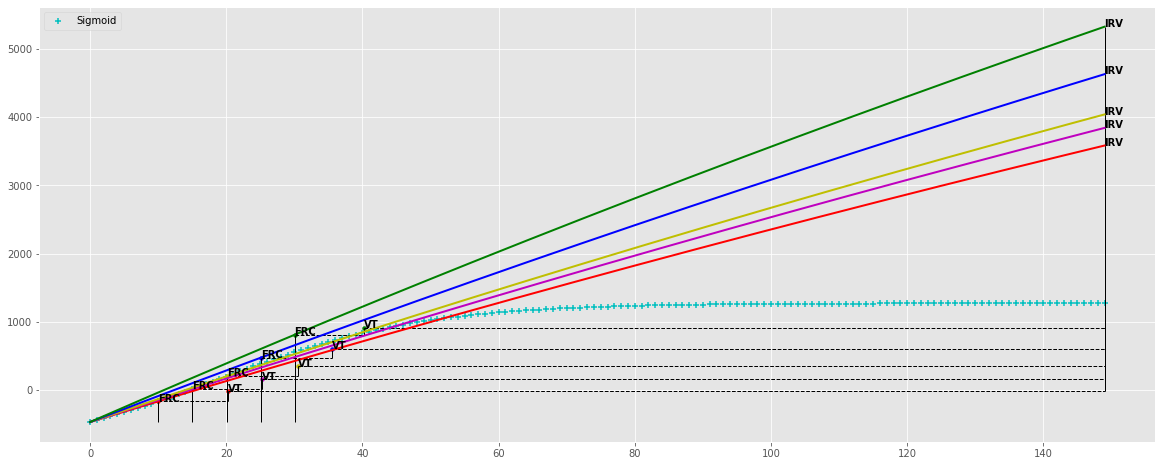

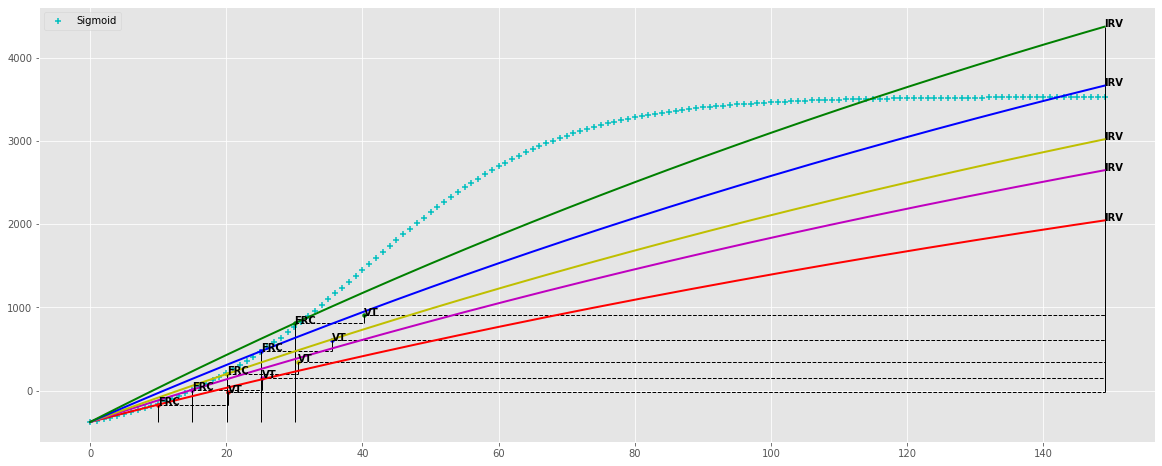

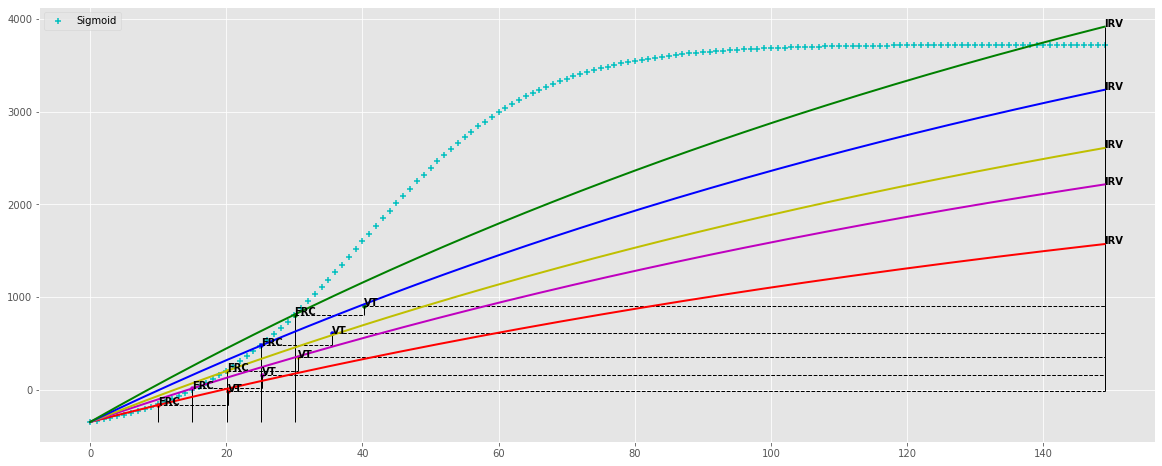

In [20]:
isPlot = {"FRC":True, "VT":True, "IRV": True, "ARP": False}
df_test[["FRC_V", "VT_V", "IRV_V", "ARP_V"]] = df_test.apply(get_volumes, args = [isPlot], axis =1, result_type = "expand")

In [21]:
df_test.filter(regex = "_V")

FRC_V  \
0   [57.04761022250878, 165.55125707309472, 369.46...   
1   [111.69456261238616, 222.97276466927093, 390.8...   
2   [46.69461988728483, 157.9728219441696, 325.834...   
3   [61.50382763146041, 164.22211986778854, 356.49...   
4   [78.47820048450922, 181.19649272083734, 373.46...   
5   [77.4575047798798, 180.17579701620792, 372.444...   
6   [98.6609194796138, 225.44667606759597, 435.911...   
7   [38.88154287055224, 145.71307439521044, 425.32...   
8   [81.91957314801368, 188.7511046726719, 468.358...   
9   [73.74519088137384, 190.8776524292254, 435.427...   
10  [104.40403722455744, 221.536498772409, 466.085...   
11  [101.15888674231479, 218.29134829016635, 462.8...   
12  [250.4995300147093, 401.6291381690062, 574.587...   
13  [63.376918705092294, 182.69529333888136, 402.7...   
14  [79.34644787827199, 198.66482251206105, 418.73...   
15  [72.03127628507212, 163.57754093350962, 315.69...   
16  [71.42185266372508, 162.96811731216258, 315.08...   
17  [36.39106589273152, 127.93733054116902, 280.05...   
18  [289.78668191190127, 437.05703141446475, 559.4...   
19  [169.8115995007023, 326.9472501354679, 523.699...   
20  [136.49643683570991, 293.63208747047554, 490.3...   
21  [234.31070591356308, 389.3827235832408, 577.22...   
22  [224.55836344441423, 379.63038111409196, 567.4...   
23  [161.47210766978753, 316.54412533946527, 504.3...   
24  [149.10205204320886, 249.29367191625573, 381.3...   
25  [182.35924305788723, 300.03085102907863, 446.5...   
26  [559.9835415156098, 677.6551494868012, 824.209...   
27  [77.51374920089839, 164.3955164738476, 305.583...   
28  [76.48515470757926, 163.36692198052847, 304.55...   
29  [76.29516820190958, 163.1769354748588, 304.364...   
30  [338.3608166224685, 522.157081270906, 752.3068...   
31  [217.64539344502901, 387.2087250490329, 608.56...   
32  [201.88348138297, 371.4468129869739, 592.80274...   
33  [245.98779201386742, 429.4251165377932, 685.03...   
34  [245.380860606007, 428.8181851299328, 684.4262...   
35  [242.23843258072816, 425.67575710465394, 681.2...   
36  [310.3692741146874, 496.743076299746, 703.2347...   
37  [236.1147446010453, 414.4903549526078, 643.237...   
38  [231.7697268476948, 410.1453371992573, 638.892...   
39  [301.2445093825244, 481.9296242430591, 672.064...   
40  [208.25680122812827, 388.94191608866294, 579.0...   
41  [182.8014161749918, 363.48653103552647, 553.62...   

                                                 VT_V  \
0   [136.291672706604, 141.49520874023438, 169.721...   
1   [126.38319778442383, 127.45170974731445, 129.4...   
2   [126.38319778442383, 127.45170974731445, 129.4...   
3   [147.45708847045898, 136.6566925048828, 174.72...   
4   [147.45708847045898, 136.6566925048828, 174.72...   
5   [147.45708847045898, 136.6566925048828, 174.72...   
6   [137.20091438293457, 165.93026208877563, 174.4...   
7   [128.0102996826172, 162.09623336791992, 189.40...   
8   [128.0102996826172, 162.09623336791992, 189.40...   
9   [121.69571304321289, 151.68694305419922, 175.9...   
10  [121.69571304321289, 151.68694305419922, 175.9...   
11  [121.69571304321289, 151.68694305419922, 175.9...   
12  [153.50567626953125, 148.29977226257324, 154.6...   
13  [139.9244155883789, 122.79812431335449, 170.00...   
14  [139.9244155883789, 122.79812431335449, 170.00...   
15  [131.94081115722656, 104.33240413665771, 114.2...   
16  [131.94081115722656, 104.33240413665771, 114.2...   
17  [131.94081115722656, 104.33240413665771, 114.2...   
18  [182.24678993225098, 142.8085174560547, 127.94...   
19  [141.30538940429688, 128.62676620483398, 111.7...   
20  [141.30538940429688, 128.62676620483398, 111.7...   
21  [155.7415771484375, 140.00226974487305, 127.85...   
22  [155.7415771484375, 140.00226974487305, 127.85...   
23  [155.7415771484375, 140.00226974487305, 127.85...   
24  [84.19008255004883, 87.99605560302734, 80.7301...   
25  [89.15105819702148, 96.74861145019531, 84.4045...   
26  [89.15105819702148, 96.74861145019531, 84.4045...   
